Data Import

In [37]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
import numpy as np
import scipy
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import datetime as dt
#necessary imports to perform the polynomial regression and evaluate it
import operator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures #generates new feature matrix with the specified degree

#for Mahalanobis distance
#from scipy.stats import chi2
#from matplotlib import patches

#Import Data

#IMO DSC Data for years 2021-2024 (ADD MISSING DATA)
data_2021 = pd.read_excel('IMO_DCS_2021.xlsx')

#Ship data for all 16 ships in scope (provided by Project Company)
ship_particulars = pd.read_excel('Ship particulars.xlsx')

In [38]:
data = [data_2021]

#Standard time format %Y-%M-%d   %H: %M: %S
def datetime_conversion(df):
    try:
        df[['Departure', 'BOSP', 'EOSP', 'Alongside', 'LastLine', 'ClosingDateTime']] = df[['Departure', 'BOSP', 'EOSP', 'Alongside', 'LastLine', 'ClosingDateTime']].apply(pd.to_datetime, format='%m/%d/%Y %H:%M')
    except:
        pass
    try:
        #2019-12-31 20:11:00
        df[['Departure', 'BOSP', 'EOSP', 'Alongside', 'LastLine', 'ClosingDateTime']] = df[['Departure', 'BOSP', 'EOSP', 'Alongside', 'LastLine', 'ClosingDateTime']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
    except:
        #19.12.2017
        df[['Departure', 'BOSP', 'EOSP', 'Alongside', 'LastLine', 'ClosingDateTime']] = df[['Departure', 'BOSP', 'EOSP', 'Alongside', 'LastLine', 'ClosingDateTime']].apply(pd.to_datetime, format='%d.%m.%Y %H:%M:%S')
    return df

def data_preparation(df):
    #Fix formatting of 'VesselName' column and apply functions defined in previous cells
    df['VesselName'] = df['VesselName'].str.upper()
    df['VesselName'] = df['VesselName'].str.replace('Ø','O')
    df['VesselName'] = df['VesselName'].str.replace('Å','AA')
    df['VesselName'] = df['VesselName'].str.replace('Æ','AE')
    df = datetime_conversion(df)
    
    return df

#format also the ship particulars vessel names to be same format as the other files
ship_particulars['VesselName'] = ship_particulars['VesselName'].str.upper()
ship_particulars['VesselName'] = ship_particulars['VesselName'].str.replace('Ø','O')
ship_particulars['VesselName'] = ship_particulars['VesselName'].str.replace('Å','AA')
ship_particulars['VesselName'] = ship_particulars['VesselName'].str.replace('Æ','AE')

def concat_dataframes(data):
    #Concat all dataframes to one (e.g data_2018 + data_2019 + data_2020 + data_2021 are all put into data_all)
    data_all = pd.concat(data, axis = 0, ignore_index=True)
    #Remove duplicates (duplicates between the years) (e.g 2019 contains 2018 and 2020 data, we keep the first occurance in accordance to fuelEU regulation)
    data_all.drop_duplicates(subset = ['FromCountryCode','ToCountryCode','ClosingDateTime','VesselName', 'ReportId', 'Departure', 'LastLine', 'ReportPeriodHrs'], keep='first', inplace=True)
    #Get the departure year (Reporting year the data belongs to), makes it possible to distinguish between each year later
    data_all['ReportingYear'] = data_all['Departure'].dt.year
    return data_all

In [41]:
data_all = concat_dataframes(data)

Data Prep for Ship Particulars and Fuel Costs

In [ ]:
#Blank for Now

## FuelEU Prep

FuelEU Preparation 
- Check EU Country and FuelEU coverage - 0%, 50% or 100%
- Check ship status in regards to port (alongside, arrival, departing), alongside = port stay
- Check if port stay is in the EU 
- Set fuel consumption at berth to 0
- Calculation of reefer days
- Fuel consumption subject to FuelEU regulation (HFO and MDO)
- Energy consumption in port (50% of AUX fuel consumption)

In [47]:
EEA_Countries = [
        "BE", "BG", "CZ", "DK", "DE", "EE", "IE", "EL", "ES", "FR",
        "HR", "IT", "CY", "LV", "LT", "LU", "HU", "MT", "NL", "AT",
        "PL", "PT", "RO", "SI", "SK", "FI", "SE",
        "IS", "NO", "LI"
    ]

#Lower Calorific Value (MJ / t)
LCV_HFO_t = 40500 
LCV_LFO_t = 41000
LCV_MDO_t = 42700

def FuelEU_prep(df,LCV_HFO,LCV_LFO,LCV_MDO):
    #Check if departure and destination ports are in EU
    #If both assign 2, if one assign 1, if none assign 0 (In accordance with paragraph c in article 2 of FuelEU regulation)

    def EU_trips(df):
    #if GFS == False:
        df.loc[(df['FromCountryCode'].isin(EEA_Countries)) & (df['ToCountryCode'].isin(EEA_Countries)), 'num_eu_ports'] = 2  
        df.loc[(df['FromCountryCode'].isin(EEA_Countries)) ^ (df['ToCountryCode'].isin(EEA_Countries)), 'num_eu_ports'] = 1
        df.loc[(~df['FromCountryCode'].isin(EEA_Countries)) & (~df['ToCountryCode'].isin(EEA_Countries)), 'num_eu_ports'] = 0

    #Check if data entry is regarding port stay, departure or arrival
    def in_port_check(df):
        df["in_port"] = False
        df.loc[(df['ReportTypeName']=="ALONGSIDE"),'in_port'] = True

    def port_arrival_check(df):
        df["port_arrival"] = False
        df.loc[(df['ReportTypeName']=="ARRIVAL"),'port_arrival'] = True

    def port_departure_check(df):
        df["port_departure"] = False
        df.loc[(df['ReportTypeName']=="DEPARTURE"),'port_departure'] = True        

    #If in port, is port in EU?
    #the "ToCountryCode" needs to be an EU country and we need to be in port
    #used further for check if we apply cold ironing or not
    def in_eu_port_check(df):
        df.loc[(df['ToCountryCode'].isin(EEA_Countries)) & (df['in_port'] == True), 'EU_port_stay'] = True
        df.loc[(~df['ToCountryCode'].isin(EEA_Countries)) | (df['in_port'] != True), 'EU_port_stay'] = False

    #Fuels - HFO (considers sulfur variants HS, ULS, VLS) and 
    #Engines - Main engine (ME), Auxiliar engine (AE) and Boiler

    #Consumption at berth
    def fuel_cons_berth(df):
        fuels = ['HS', 'ULS', 'VLS', 'MDO']
        for i in fuels:
            df[f'fuel_cons_at_berth_{i}'] = 0 #set fuel cons column for each fuel to 0 at start
        
        #we are missing inPort consumption information for 2018 and 2019, therefore we assume that we can take the entire Aux Eng consumption into account.
        #However, when later applying FuelEU and cold ironing we realised this was unrealistic. Looking at the shares this is later reduced to 50% when actually applying cold ironing.
        #What should we do?
        df.loc[(df['in_port'] == True), 'fuel_cons_at_berth_HS'] = df['ConsAuxHS']      
        df.loc[(df['in_port'] == True), 'fuel_cons_at_berth_ULS'] = df['ConsAuxULS']      
        df.loc[(df['in_port'] == True), 'fuel_cons_at_berth_VLS'] = df['ConsAuxVLS']      
        df.loc[(df['in_port'] == True), 'fuel_cons_at_berth_MDO'] = df['ConsAuxMDO']

    #Calculating the reefer days
    #What to do with this???
    def reefer_days(df):
        #as no. of reefers are only noted at departure of a leg, we need to fill the entire leg with this number. (e.g At departure we know it's 500 reefers, then it has to be 500 for each row until we arrive at port.)
        df.NoOfReefers = df.groupby(['VesselName','FromPortName','ToPortName','Departure','LastLine']).NoOfReefers.transform('first')
        #in accordance to regulation, the number of reefers in port should be the average of reefers at arrival and at departure (if these data points exist) (2022 Interim Guidelines on correction factors and voyage adjustments for CII calculations (CII Guidelines, G5). MEPC.355(78) Annex 17.)
        #for new data, the value that is reported in the single line is kept as there is there are seperate rows for arrival, port, departure
        df.loc[(df['in_port'] == True) & (df['port_arrival'].shift(1)==True) & (df['port_departure'].shift(-1)==True), 'NoOfReefers'] = (df['NoOfReefers'].shift(-1)+df['NoOfReefers'].shift(1))/2
        #calculate reefers days by multiplying number of reefers in a reporting period with the hours, divided by 24
        df['reefer_days'] = df['NoOfReefers']*df['ReportPeriodHrs']/24

    #FuelEU related consumption values - What share of the fuel consumption of a voyage should be accounted for in the FuelEU regulation
    def fuel_eu_related_consumption(df):
        fuels = ['HS', 'ULS', 'VLS', 'MDO']
        engines = ['ME','Aux', 'Boil']
        
        for fuel in fuels:
            for engine in engines:
                #if GFS == False: #FuelEU case
                df.loc[(df['num_eu_ports'] == 2), 'FuelEU_Related_{}_cons_{}'.format(fuel, engine)] = df['Cons{}{}'.format(engine,fuel)] #both from and to part are in EU -> account for entire fuel consumption
                df.loc[(df['num_eu_ports'] == 1), 'FuelEU_Related_{}_cons_{}'.format(fuel, engine)] = df['Cons{}{}'.format(engine,fuel)]*0.5 #only one port in EU -> account for 50% of fuel consumption
                df.loc[(df['num_eu_ports'] == 0), 'FuelEU_Related_{}_cons_{}'.format(fuel, engine)] = df['Cons{}{}'.format(engine,fuel)]*0 #no part in EU -> not applicable for Fuel EU
                df['{}_consumption_{}'.format(fuel, engine)] = df['Cons{}{}'.format(engine,fuel)]

    #Energy Consumption at berth
    #we assume that the fuel consumption of half Alongside-Period is happening at berth (as opposed to some data where we can distinguish the fuel consumption at berth from arriving/departing from berth)
    #we have fuel onsumption at berth above - should we use it ??
    #include boiler consumption
    def energy_at_berth(df, LCV_HFO,LCV_LFO, LCV_MDO):
        #LCV in Joule
        #we are missing inPort consumption information for 2018 and 2019, therefore we assume that we can take half Aux Eng consumption into account. Previously we took entire consumption but that was over-estimating the values as we also approach the port etc.
        df.loc[(df['in_port'] == False), 'energy_at_berth'] = 0
        df.loc[(df['in_port'] == True), 'energy_at_berth_FuelEU'] = (df['FuelEU_Related_HS_cons_Aux']*LCV_HFO_t + df['FuelEU_Related_MDO_cons_Aux']*LCV_MDO_t + df['FuelEU_Related_ULS_cons_Aux']*LCV_LFO_t + df['FuelEU_Related_VLS_cons_Aux']*LCV_LFO_t)*0.5     
        df.loc[(df['in_port'] == True), 'energy_at_berth'] = (df['ConsAuxHS']*LCV_HFO_t + df['ConsAuxULS']*LCV_LFO_t + df['ConsAuxVLS']*LCV_LFO_t + df['ConsAuxMDO']*LCV_MDO_t)*0.5
        df.loc[(df['EU_port_stay'] == True), 'energy_at_berth_EU'] = df['energy_at_berth_FuelEU']
        df.loc[(df['EU_port_stay'] == False), 'energy_at_berth_EU'] = 0

    EU_trips(df)
    in_port_check(df)
    port_arrival_check(df)
    port_departure_check(df)
    in_eu_port_check(df)
    fuel_cons_berth(df)
    reefer_days(df)
    fuel_eu_related_consumption(df)
    energy_at_berth(df,LCV_HFO_t,LCV_LFO_t,LCV_MDO_t)
    return df
                

Apply all data preparation to update dataframe

In [48]:
df_prep = []

for df in data:
    df_prep.append(data_preparation(df))

data_all = concat_dataframes(df_prep) #apply concatenation and eliminate duplicates
data_all = data_all[~data_all['LastLine'].isna()] #remove voyage without destination
data_all = data_all[~data_all['Departure'].isna()] #remove voyage without departure 
data_all = data_all.fillna(0) #fill missing values with 0s

#perform fuel eu related data preparations
data_all = FuelEU_prep(data_all,LCV_HFO_t,LCV_LFO_t,LCV_MDO_t)

data_all = data_all.fillna(0) #fill missing values with 0s after prep


C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\3504831816.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['in_port'] == True), 'fuel_cons_at_berth_HS'] = df['ConsAuxHS']
C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\3504831816.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['in_port'] == True), 'fuel_cons_at_berth_ULS'] = df['ConsAuxULS']
C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\3504831816.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.7  1.72 6.19 ... 2.6  4

In [49]:
data_all.head()

,ImoNo,MLCode,VesselName,VoyageNo,VoyageStatus,DSC,VesselId,ReportId,ReportTypeId,ReportTypeName,ReportPeriodHrs,ClosingDateTime,FromPortCode,FromPortName,FromCountryCode,ToPortCode,ToPortName,ToCountryCode,Departure,BOSP,EOSP,Alongside,LastLine,BallastWater,DistanceGPS,SpeedGPS,AnchorageHrs,DriftingHrs,TimeAtSeaHours,DraughtFore,DraughtAft,AUXBlowerEnergy,AUX1Energy,AUX1RunHrs,AUX2Energy,AUX2RunHrs,AUX3Energy,AUX3RunHrs,AUX4Energy,AUX4RunHrs,AUX5Energy,AUX5RunHrs,ME1Power,ME1RPM,ME1RunHrs,ME2Power,ME2RPM,ME2RunHrs,NoOfReefers,ReeferPower,ReeferCoolerPumpPower,SG1Energy,SG1RunHrs,SG2Energy,SG2RunHrs,SM1Energy,SM1RunHrs,SM2Energy,SM2RunHrs,WHREnergy,WHRRunHrs,ConsMEHS,ConsMEULS,ConsMEVLS,ConsMEMDO,ConsAuxHS,ConsAuxULS,ConsAuxVLS,ConsAuxMDO,ConsBoilHS,ConsBoilULS,ConsBoilVLS,ConsBoilMDO,SulphurHS,SulphurVLS,SulphurULS,SulphurMDO,TEUReported,NoOf20Full,NoOf20Empty,NoOf40Full,NoOf40Empty,NoOf45Full,NoOf45Empty,NoOfOtherFull,NoOfOtherEmpty,NoOfOOG,NoOfReeferContainers,VerifiedGrossMassKG,WeightOf20Empty,WeightOf20Full,TotalWeightOf20,WeightOf40Empty,WeightOf40Full,TotalWeightOf40,WeightOf45Empty,WeightOf45Full,TotalWeightOf45,WeightOfOtherEmpty,WeightOfOtherFull,TotalWeightOfOther,WeightOfOOG,TotalWeightOfContainers,BunkerTimeForFuelUTC,BunkerHSLastLine,BunkerULSLastLine,BunkerVLSLastLine,BunkerMDOLastLine,StockTimeForFuelUTC,StockHSLastLine,StockVLSLastLine,StockULSLastLine,StockMDOLastLine,FleetGroup,FromPortCodeABS,ToPortCodeABS,ReportingYear,num_eu_ports,in_port,port_arrival,port_departure,EU_port_stay,fuel_cons_at_berth_HS,fuel_cons_at_berth_ULS,fuel_cons_at_berth_VLS,fuel_cons_at_berth_MDO,reefer_days,FuelEU_Related_HS_cons_ME,HS_consumption_ME,FuelEU_Related_HS_cons_Aux,HS_consumption_Aux,FuelEU_Related_HS_cons_Boil,HS_consumption_Boil,FuelEU_Related_ULS_cons_ME,ULS_consumption_ME,FuelEU_Related_ULS_cons_Aux,ULS_consumption_Aux,FuelEU_Related_ULS_cons_Boil,ULS_consumption_Boil,FuelEU_Related_VLS_cons_ME,VLS_consumption_ME,FuelEU_Related_VLS_cons_Aux,VLS_consumption_Aux,FuelEU_Related_VLS_cons_Boil,VLS_consumption_Boil,FuelEU_Related_MDO_cons_ME,MDO_consumption_ME,FuelEU_Related_MDO_cons_Aux,MDO_consumption_Aux,FuelEU_Related_MDO_cons_Boil,MDO_consumption_Boil,energy_at_berth,energy_at_berth_FuelEU,energy_at_berth_EU
0,9064384,165,MAERSK TAASINGE,2031,0,12284300,188,4393078,3,DEPARTURE,4.2,2020-12-23 01:30:00,DLA,DOUALA,CM,PNR,POINTE NOIRE,CG,2020-12-22 21:18:00,2020-12-23 01:30:00,2020-12-25 12:00:00,2021-01-04 14:18:00,2021-01-06 15:24:00,0.0,25.0,5.952381,0.0,0.0,4.2,8.3,8.3,193.0,990.0,3.8,650.0,2.4,110,0.4,0.0,0.0,0,0.0,0,51.9,4.2,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,1.05,0.0,0.0,0.0,0.42,0.0,0.0,0.0,0.00,0.0,0.0,0.47,0.0,0.0,0,215,0,386,39,0,0,0,0,0,0,15033548,0,2580,2580,156,9264,9420,0.0,0,0.0,0,0,0,0,12000.0,0,0.0,0.0,0.0,0.0,2020-12-22 21:18:00,0.0,396.25,0.0,34.75,0.0,CMDLA,CGPNR,2020,0.0,False,False,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.05,0.0,0.42,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9064384,165,MAERSK TAASINGE,2031,0,0,188,4393754,0,SEA,31.5,2020-12-24 09:00:00,DLA,DOUALA,CM,PNR,POINTE NOIRE,CG,2020-12-22 21:18:00,2020-12-23 01:30:00,2020-12-25 12:00:00,2021-01-04 14:18:00,2021-01-06 15:24:00,610.0,319.0,10.126984,0.0,0.0,31.5,8.3,8.3,1459.0,330.0,0.9,12990.0,31.5,0,0.0,0.0,0.0,0,0.0,2966,75.6,31.5,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,17.60,0.0,0.0,0.0,3.24,0.0,0.0,0.0,0.00,0.0,0.0,0.47,0.0,0.0,0,215,0,386,39,0,0,0,0,0,0,15033548,0,2580,2580,156,9264,9420,0.0,0,0.0,0,0,0,0,12000.0,0,0.0,0.0,0.0,0.0,0,0.0,0.00,0.0,0.00,0.0,CMDLA,CGPNR,2020,0.0,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.60,0.0,3.24,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9064384,165,MAERSK TAASINGE,2031,0,0,188,4394778,0,SEA,27.0,2020-12-25 12:00:00,DLA,DOUALA,CM,PNR,POINTE NOIRE,CG,2020-12-22 21:18:00,2020-12-23 01:30:00,2020-12-25 12:00:00,2021-01-04 14:18:00,2021-01-06 15:24:00,610

## CO2 Emissions Calculations

In [50]:
#Wake to Tank(WtT) factors
wtt_ghg_HFO = 13.5
wtt_ghg_LFO = 13.2
wtt_ghg_MDO = 14.4

#Tank to Whell (TtW) factors
ttw_ghg_HFO = 3.114
ttw_ghg_LFO = 3.151
ttw_ghg_MDO = 3.206

LCV_HFO_t = 0.040500 
LCV_LFO_t = 0.041000
LCV_MDO_t = 0.042700

#Emissions for all years
#take all engines into account (total consumption over e.g. all auxiliary engines)
engines = ["ME","Aux","Boil"]

#For Well to Tank Emissions (issing LCV?)
for engine in engines:
    data_all[f"{engine}_Emissions_wtt [tCO2eq]"] = (data_all[f"Cons{engine}HS"]*LCV_HFO_t*wtt_ghg_HFO + data_all[f"Cons{engine}MDO"]*LCV_MDO_t*wtt_ghg_MDO + data_all[f"Cons{engine}VLS"]*LCV_LFO_t*wtt_ghg_LFO + data_all[f"Cons{engine}ULS"]*LCV_LFO_t*wtt_ghg_LFO)

#For Tank to Wheel
for engine in engines:
    data_all[f"{engine}_Emissions_ttw [tCO2eq]"] = (data_all[f"Cons{engine}HS"]*LCV_HFO_t*ttw_ghg_HFO + data_all[f"Cons{engine}MDO"]*LCV_MDO_t*ttw_ghg_MDO + data_all[f"Cons{engine}VLS"]*LCV_LFO_t*ttw_ghg_LFO + data_all[f"Cons{engine}ULS"]*LCV_LFO_t*ttw_ghg_LFO)

#Total Emissions for Engine
for engine in engines:
    data_all[f"{engine}_Emissions_wtw [tCO2eq]"] = data_all[f"{engine}_Emissions_wtt [tCO2eq]"] + data_all[f"{engine}_Emissions_ttw [tCO2eq]"]

data_all['Total CO2 Emissions [tCO2eq]'] = data_all["ME_Emissions_wtw [tCO2eq]"] + data_all["Aux_Emissions_wtw [tCO2eq]"] + data_all["Boil_Emissions_wtw [tCO2eq]"]
data_all.head()



,ImoNo,MLCode,VesselName,VoyageNo,VoyageStatus,DSC,VesselId,ReportId,ReportTypeId,ReportTypeName,ReportPeriodHrs,ClosingDateTime,FromPortCode,FromPortName,FromCountryCode,ToPortCode,ToPortName,ToCountryCode,Departure,BOSP,EOSP,Alongside,LastLine,BallastWater,DistanceGPS,SpeedGPS,AnchorageHrs,DriftingHrs,TimeAtSeaHours,DraughtFore,DraughtAft,AUXBlowerEnergy,AUX1Energy,AUX1RunHrs,AUX2Energy,AUX2RunHrs,AUX3Energy,AUX3RunHrs,AUX4Energy,AUX4RunHrs,AUX5Energy,AUX5RunHrs,ME1Power,ME1RPM,ME1RunHrs,ME2Power,ME2RPM,ME2RunHrs,NoOfReefers,ReeferPower,ReeferCoolerPumpPower,SG1Energy,SG1RunHrs,SG2Energy,SG2RunHrs,SM1Energy,SM1RunHrs,SM2Energy,SM2RunHrs,WHREnergy,WHRRunHrs,ConsMEHS,ConsMEULS,ConsMEVLS,ConsMEMDO,ConsAuxHS,ConsAuxULS,ConsAuxVLS,ConsAuxMDO,ConsBoilHS,ConsBoilULS,ConsBoilVLS,ConsBoilMDO,SulphurHS,SulphurVLS,SulphurULS,SulphurMDO,TEUReported,NoOf20Full,NoOf20Empty,NoOf40Full,NoOf40Empty,NoOf45Full,NoOf45Empty,NoOfOtherFull,NoOfOtherEmpty,NoOfOOG,NoOfReeferContainers,VerifiedGrossMassKG,WeightOf20Empty,WeightOf20Full,TotalWeightOf20,WeightOf40Empty,WeightOf40Full,TotalWeightOf40,WeightOf45Empty,WeightOf45Full,TotalWeightOf45,WeightOfOtherEmpty,WeightOfOtherFull,TotalWeightOfOther,WeightOfOOG,TotalWeightOfContainers,BunkerTimeForFuelUTC,BunkerHSLastLine,BunkerULSLastLine,BunkerVLSLastLine,BunkerMDOLastLine,StockTimeForFuelUTC,StockHSLastLine,StockVLSLastLine,StockULSLastLine,StockMDOLastLine,FleetGroup,FromPortCodeABS,ToPortCodeABS,ReportingYear,num_eu_ports,in_port,port_arrival,port_departure,EU_port_stay,fuel_cons_at_berth_HS,fuel_cons_at_berth_ULS,fuel_cons_at_berth_VLS,fuel_cons_at_berth_MDO,reefer_days,FuelEU_Related_HS_cons_ME,HS_consumption_ME,FuelEU_Related_HS_cons_Aux,HS_consumption_Aux,FuelEU_Related_HS_cons_Boil,HS_consumption_Boil,FuelEU_Related_ULS_cons_ME,ULS_consumption_ME,FuelEU_Related_ULS_cons_Aux,ULS_consumption_Aux,FuelEU_Related_ULS_cons_Boil,ULS_consumption_Boil,FuelEU_Related_VLS_cons_ME,VLS_consumption_ME,FuelEU_Related_VLS_cons_Aux,VLS_consumption_Aux,FuelEU_Related_VLS_cons_Boil,VLS_consumption_Boil,FuelEU_Related_MDO_cons_ME,MDO_consumption_ME,FuelEU_Related_MDO_cons_Aux,MDO_consumption_Aux,FuelEU_Related_MDO_cons_Boil,MDO_consumption_Boil,energy_at_berth,energy_at_berth_FuelEU,energy_at_berth_EU,ME_Emissions_wtt [tCO2eq],Aux_Emissions_wtt [tCO2eq],Boil_Emissions_wtt [tCO2eq],ME_Emissions_ttw [tCO2eq],Aux_Emissions_ttw [tCO2eq],Boil_Emissions_ttw [tCO2eq],ME_Emissions_wtw [tCO2eq],Aux_Emissions_wtw [tCO2eq],Boil_Emissions_wtw [tCO2eq],Total CO2 Emissions [tCO2eq]
0,9064384,165,MAERSK TAASINGE,2031,0,12284300,188,4393078,3,DEPARTURE,4.2,2020-12-23 01:30:00,DLA,DOUALA,CM,PNR,POINTE NOIRE,CG,2020-12-22 21:18:00,2020-12-23 01:30:00,2020-12-25 12:00:00,2021-01-04 14:18:00,2021-01-06 15:24:00,0.0,25.0,5.952381,0.0,0.0,4.2,8.3,8.3,193.0,990.0,3.8,650.0,2.4,110,0.4,0.0,0.0,0,0.0,0,51.9,4.2,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,1.05,0.0,0.0,0.0,0.42,0.0,0.0,0.0,0.00,0.0,0.0,0.47,0.0,0.0,0,215,0,386,39,0,0,0,0,0,0,15033548,0,2580,2580,156,9264,9420,0.0,0,0.0,0,0,0,0,12000.0,0,0.0,0.0,0.0,0.0,2020-12-22 21:18:00,0.0,396.25,0.0,34.75,0.0,CMDLA,CGPNR,2020,0.0,False,False,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.05,0.0,0.42,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56826,0.227304,0.000000,0.135651,0.054260,0.000000,0.703911,0.281564,0.000000,0.985475
1,9064384,165,MAERSK TAASINGE,2031,0,0,188,4393754,0,SEA,31.5,2020-12-24 09:00:00,DLA,DOUALA,CM,PNR,POINTE NOIRE,CG,2020-12-22 21:18:00,2020-12-23 01:30:00,2020-12-25 12:00:00,2021-01-04 14:18:00,2021-01-06 15:24:00,610.0,319.0,10.126984,0.0,0.0,31.5,8.3,8.3,1459.0,330.0,0.9,12990.0,31.5,0,0.0,0.0,0.0,0,0.0,2966,75.6,31.5,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,17.60,0.0,0.0,0.0,3.24,0.0,0.0,0.0,0.00,0.0,0.0,0.47,0.0,0.0,0,215,0,386,39,0,0,0,0,0,0,15033548,0,2580,2580,156,9264,9420,0.0,0,0.0,0,0,0,0,12000.0,0,0.0,0.0,0.0,0.0,0,0.0,0.00,0.0,0.00,0.0,CMDLA,CGPNR,2020,0.0,False,False,Fa

## Exploratory Data Analysis

In [51]:
print("Summary Statistics: \n") #Check maximum, minimum, average and standard deviation values for each data file (before merging)

EDA_2021 = data_2021.loc[data_2021['VesselName'].isin(ship_particulars['VesselName'])] #Include ship particulars excel
temp = data_2021[['ReportPeriodHrs', 'DistanceGPS', 'SpeedGPS', 'AnchorageHrs', 'ME1Power', 'ME1RunHrs', 'NoOfReefers', 'ConsMEHS', 'ConsMEVLS', 'ConsMEULS', 'ConsMEMDO']]
temp.describe()   

Summary Statistics: 



,ReportPeriodHrs,DistanceGPS,SpeedGPS,AnchorageHrs,ME1Power,ME1RunHrs,NoOfReefers,ConsMEHS,ConsMEVLS,ConsMEULS,ConsMEMDO
count,134597.000000,134597.000000,134597.000000,134597.000000,134597.000000,134597.000000,134597.000000,134597.000000,134597.000000,134597.000000,134597.000000
mean,19.597528,191.918619,12.559275,0.280715,8774.818361,12.286318,26.134519,9.887822,21.328533,2.421088,0.644049
std,31.554493,187.262819,66.454156,7.074335,9747.021188,11.220605,125.682879,33.537401,35.719877,10.772979,5.231449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.800000,13.000000,4.818405,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19.500000,131.300000,12.371622,0.000000,5785.000000,10.000000,0.000000,0.000000,1.460000,0.000000,0.000000
75%,24.000000,363.200000,17.283333,0.000000,14200.000000,24.000000,0.000000,0.000000,30.010000,0.000000,0.000000
max,1992.533333,5972.000000,16680.000000,717.700000,51990.000000,453.000000,18833.000000,295.700000,639.300000,280.700000,204.000000


Missing Data

In [52]:
#merge all data
data_all_temp = data_all.merge(ship_particulars, on="VesselName") #merge the ships particulars so we only have the ships we want
data_all_temp_grouped = data_all_temp.groupby(by=["VesselName","ReportingYear"]).agg({'ReportId':'count'}).reset_index()

print(data_all_temp_grouped.loc[data_all_temp_grouped["ReportingYear"]==2021].head(20))

print('number of ships in 2021:', len(data_all_temp_grouped.loc[data_all_temp_grouped["ReportingYear"]==2021].head(20)))



          VesselName  ReportingYear  ReportId
1         CAP CARMEL           2021       368
3        EMMA MAERSK           2021       390
5     ESTELLE MAERSK           2021       431
7       GRETE MAERSK           2021       438
9      GUDRUN MAERSK           2021       435
11    MAERSK BERMUDA           2021       461
13    MAERSK CONAKRY           2021       487
15  MAERSK EDINBURGH           2021       408
17       MAERSK SANA           2021       450
19      MONTE ALEGRE           2021       471
21   MONTE CERVANTES           2021       479
23        MONTE ROSA           2021       395
25       SANTA CLARA           2021       410
number of ships in 2021: 13


Printing columns in each year where there are NANs.
------------------------------------------------------------------------------------------------------------
Missing values in data_2021 are: ['VoyageNo', 'VoyageStatus', 'FromCountryCode', 'ToCountryCode', 'BunkerTimeForFuelUTC', 'StockTimeForFuelUTC', 'FleetGroup', 'FromPortCodeABS', 'ToPortCodeABS'] 

Share of missing FromCountryCode in data_2021 is 0.52 %
Share of missing ToCountryCode in data_2021 is 0.5 %
Share of missing AnchorageHrs in data_2021 is 0.0 %
----------------------------------------------------------------------


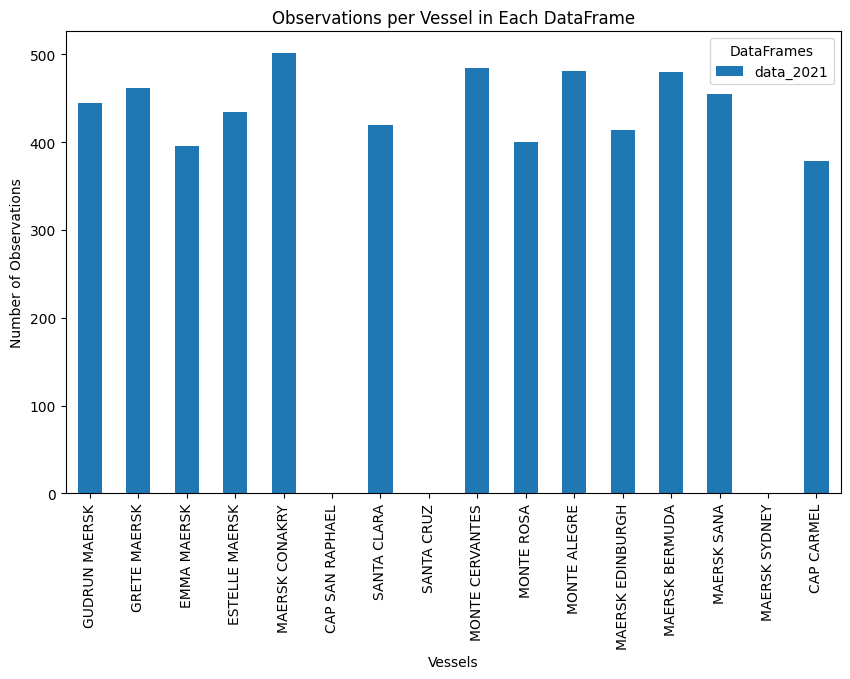

In [53]:
#Missing Values

data = [data_2021] #Include data for other years
data_names = ['data_2021'] #Include data for other years

print('Printing columns in each year where there are NANs.')
print('------------------------------------------------------------------------------------------------------------')

for df in range(len(data)):
    missing = data[df].columns[data[df].isna().any()].tolist()
    print('Missing values in', data_names[df] ,'are:' ,missing, '\n')

#Based on above we see that there are missing values in some of the columns for every year. Looking at the columns that are missing none of them are however critical. The one column that is of most imporance that we are missing is FromCountryCode and ToCountryCode. In the worst case this could mean that we exclude either half or the entire voyage from fuelEU

for df in range(len(data)):
    #temp = data[df].loc[data[df]['VesselName'].isin(ship_particulars['VesselName'])] #CHECK JUST FOR VESSELS IN SHIP PARTICULARS
    temp=data[df]
    print('Share of missing FromCountryCode in', data_names[df],'is',round(len(temp.loc[temp['FromCountryCode'].isna()==True])/len(temp)*100,2), '%')
    print('Share of missing ToCountryCode in', data_names[df],'is',round(len(temp.loc[temp['ToCountryCode'].isna()==True])/len(temp)*100,2), '%')
    print('Share of missing AnchorageHrs in', data_names[df],'is',round(len(temp.loc[temp['AnchorageHrs'].isna()==True])/len(temp)*100,2), '%')

    print('----------------------------------------------------------------------')

#NUmber of Observations

import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is a list of DataFrames and ship_particulars is a DataFrame
selected_vessels = ship_particulars['VesselName'].unique()

# Create a dictionary to store observations for each vessel
observations_dict = {vessel: [len(df[df['VesselName'] == vessel]) for df in data] for vessel in selected_vessels}

# Create a DataFrame from the dictionary
observations_df = pd.DataFrame(observations_dict, index=data_names)

# Transpose the DataFrame for plotting
observations_df_transposed = observations_df.T

# Plot the bar chart
observations_df_transposed.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Observations per Vessel in Each DataFrame')
plt.xlabel('Vessels')
plt.ylabel('Number of Observations')
plt.legend(title='DataFrames', bbox_to_anchor=(1, 1))
plt.show()


## Distribution and Outliers


### Reporting Hours

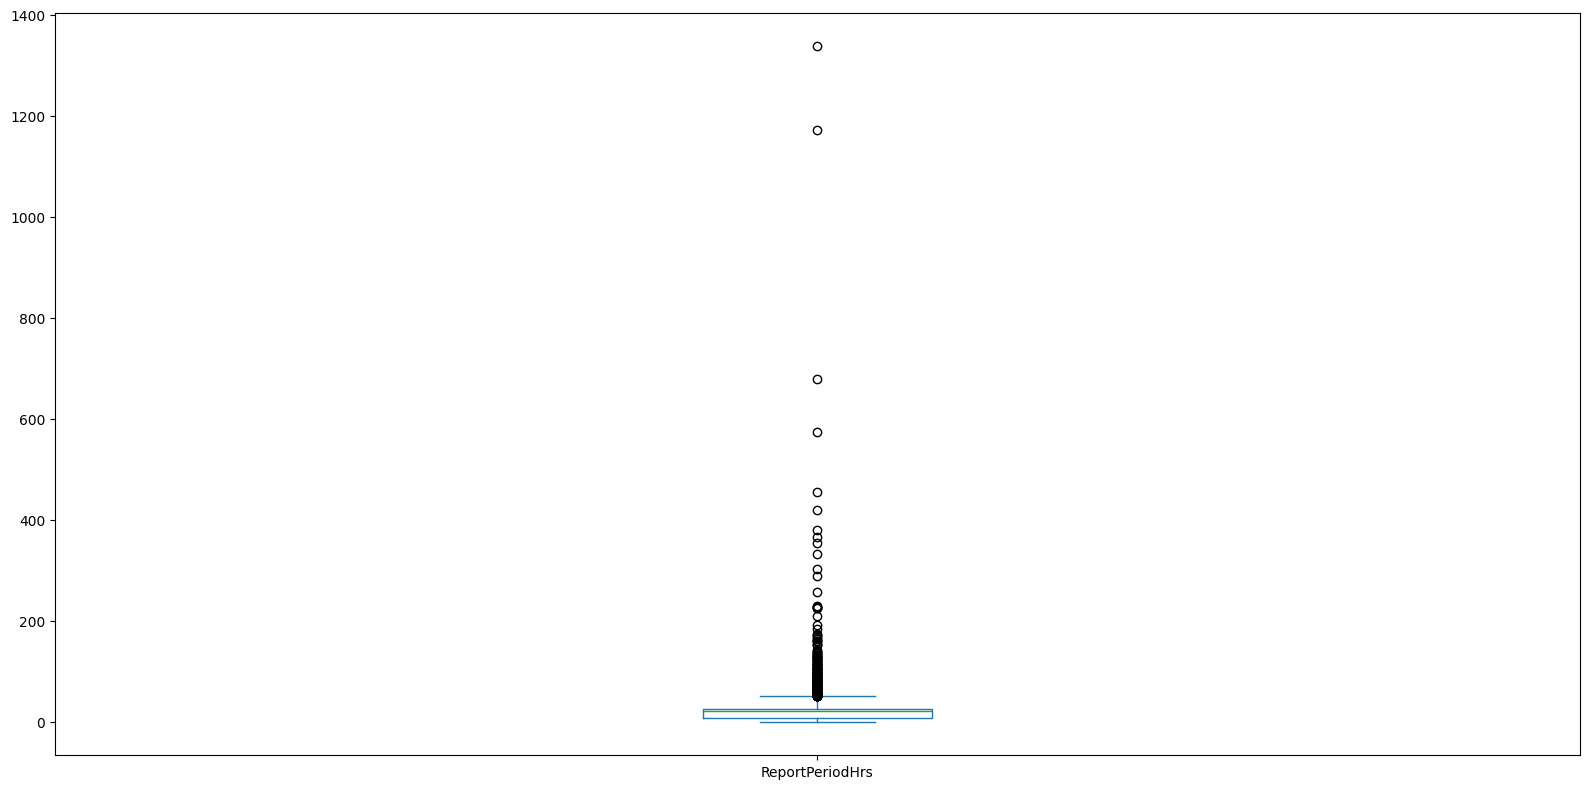

,VesselName,ReportPeriodHrs
50531,EMMA MAERSK,1337.583333
118199,MAERSK BERMUDA,1172.300000
89763,MAERSK CONAKRY,678.700000
27325,CAP CARMEL,574.200000
89853,MAERSK CONAKRY,455.066667


In [54]:
#Check outliers in Reporting Period Hours - very high reporting hours can be odd
#Check Report Type / Type of journey
df = data_2021.loc[data_2021['VesselName'].isin(ship_particulars['VesselName'])]

df['ReportPeriodHrs'].plot(kind='box', figsize = (16,8))
plt.tight_layout()  
plt.show()
df[['VesselName', 'ReportPeriodHrs']].sort_values(by='ReportPeriodHrs', ascending=False).head(5)


### To/From Country

In [55]:
df = data_2021[['VesselName', 'FromCountryCode', 'ToCountryCode']]
df = df.loc[df['VesselName'].isin(ship_particulars['VesselName'])]
df[df.isna().any(axis=1)].head(5)

,VesselName,FromCountryCode,ToCountryCode
90157,MAERSK CONAKRY,BJ,NaN
90158,MAERSK CONAKRY,BJ,NaN
90159,MAERSK CONAKRY,BJ,NaN
90160,MAERSK CONAKRY,BJ,NaN
90161,MAERSK CONAKRY,BJ,NaN


### Distributions

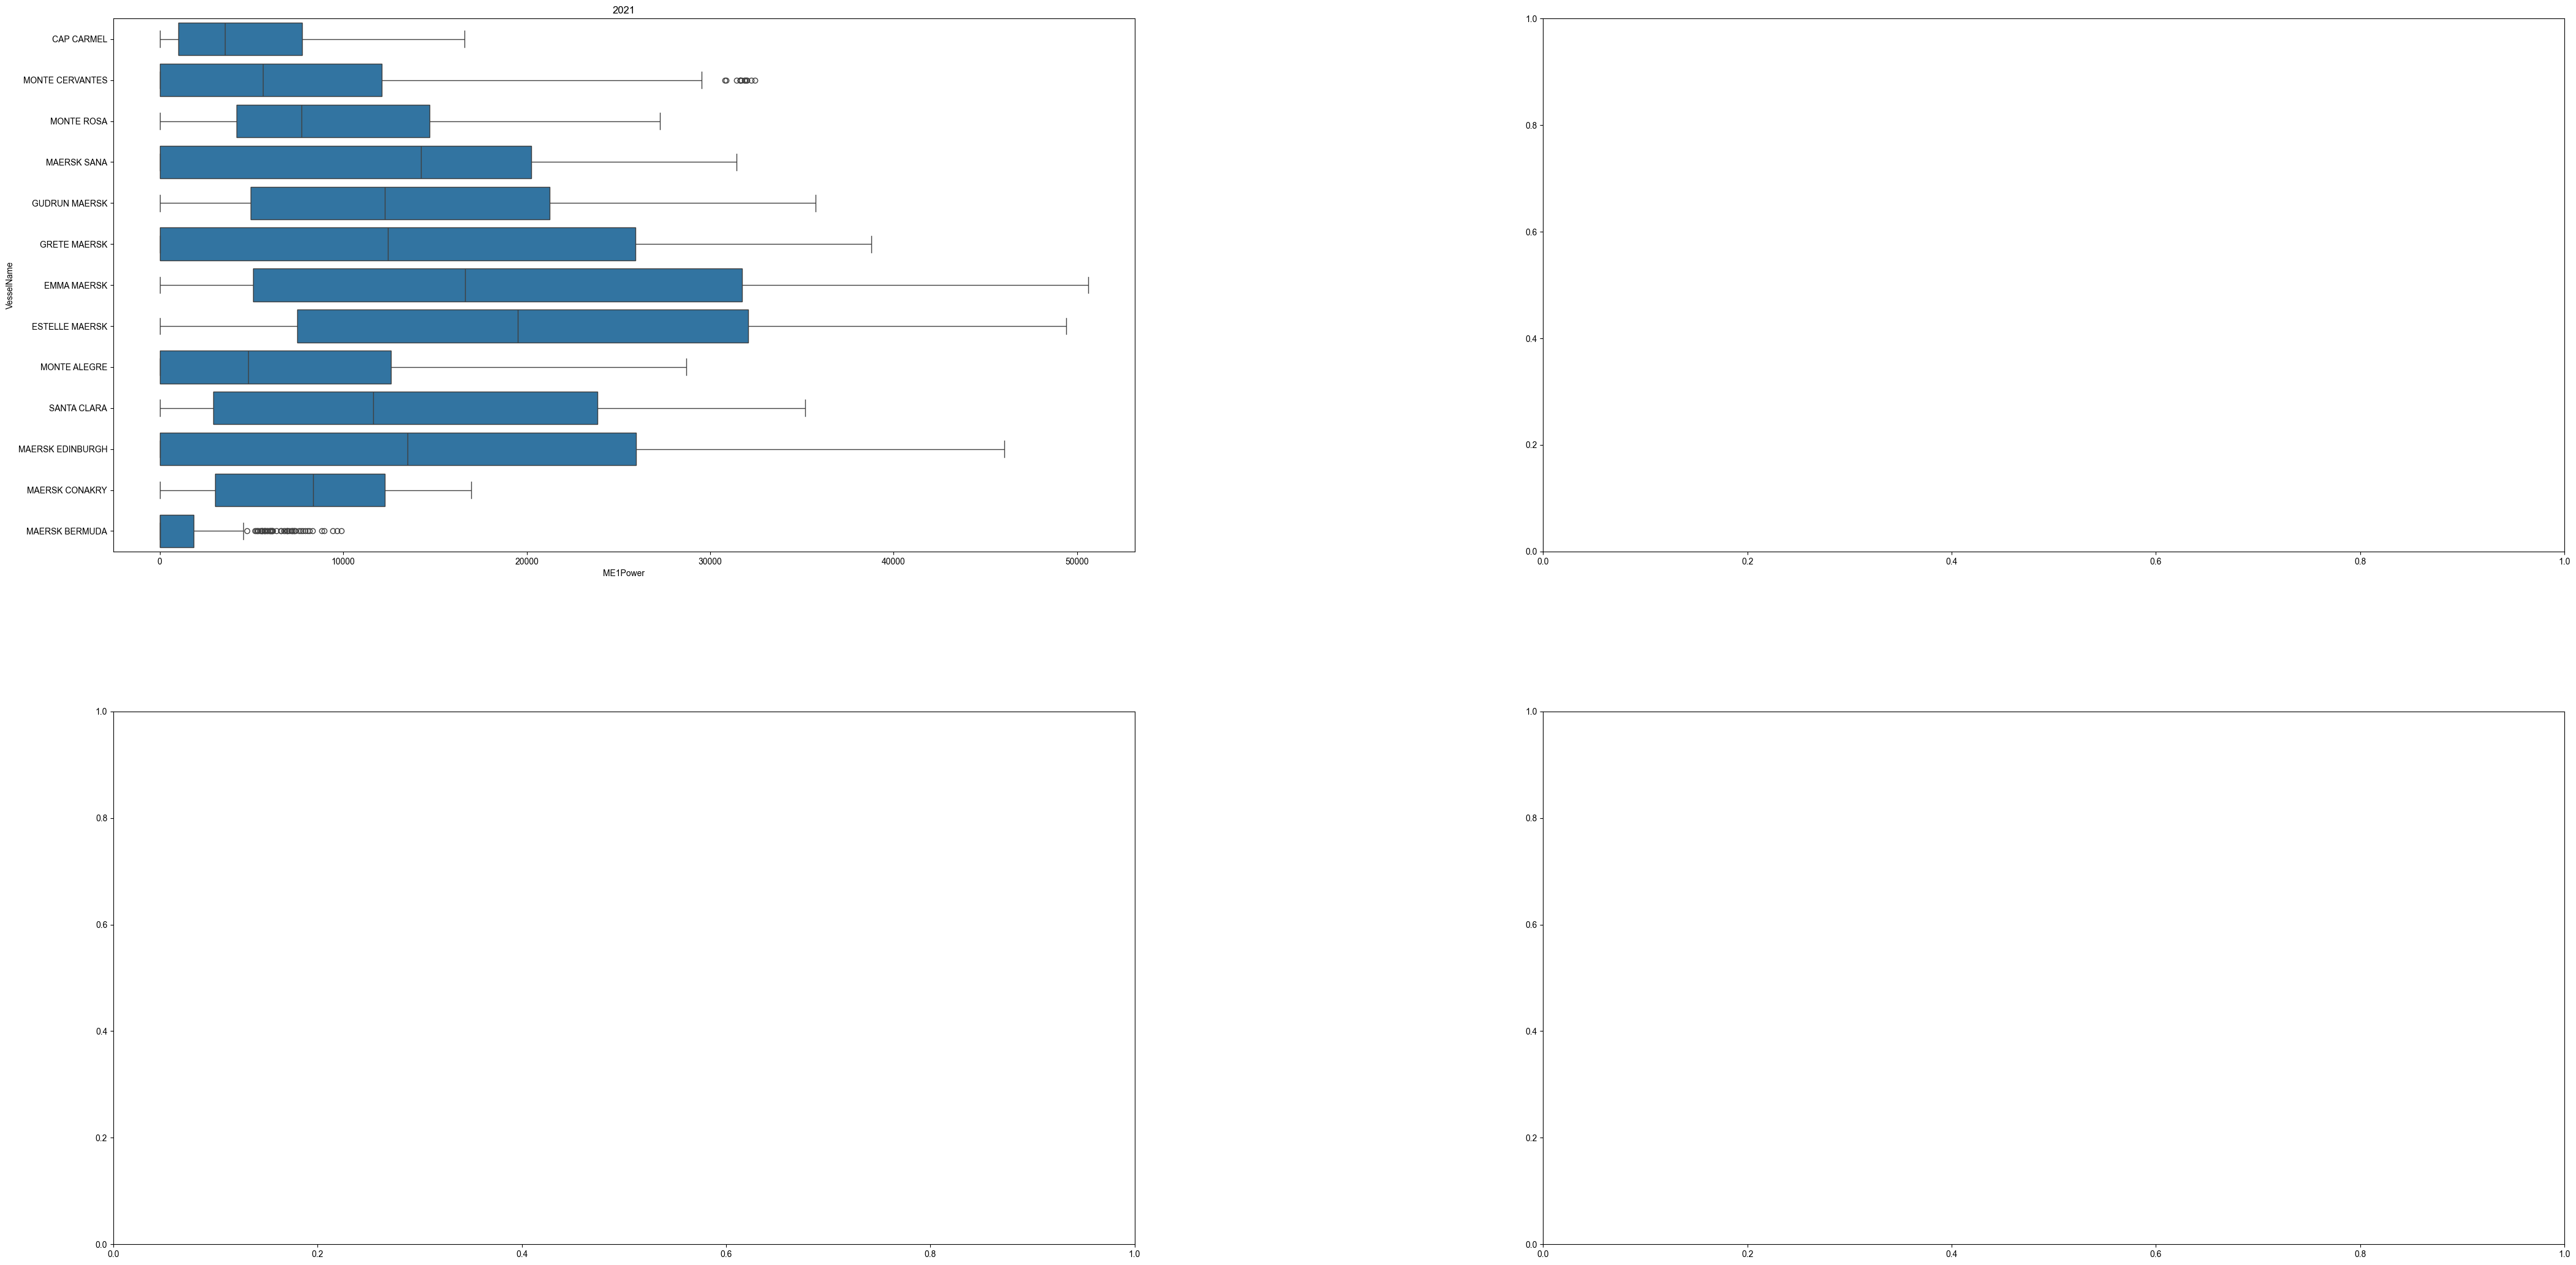

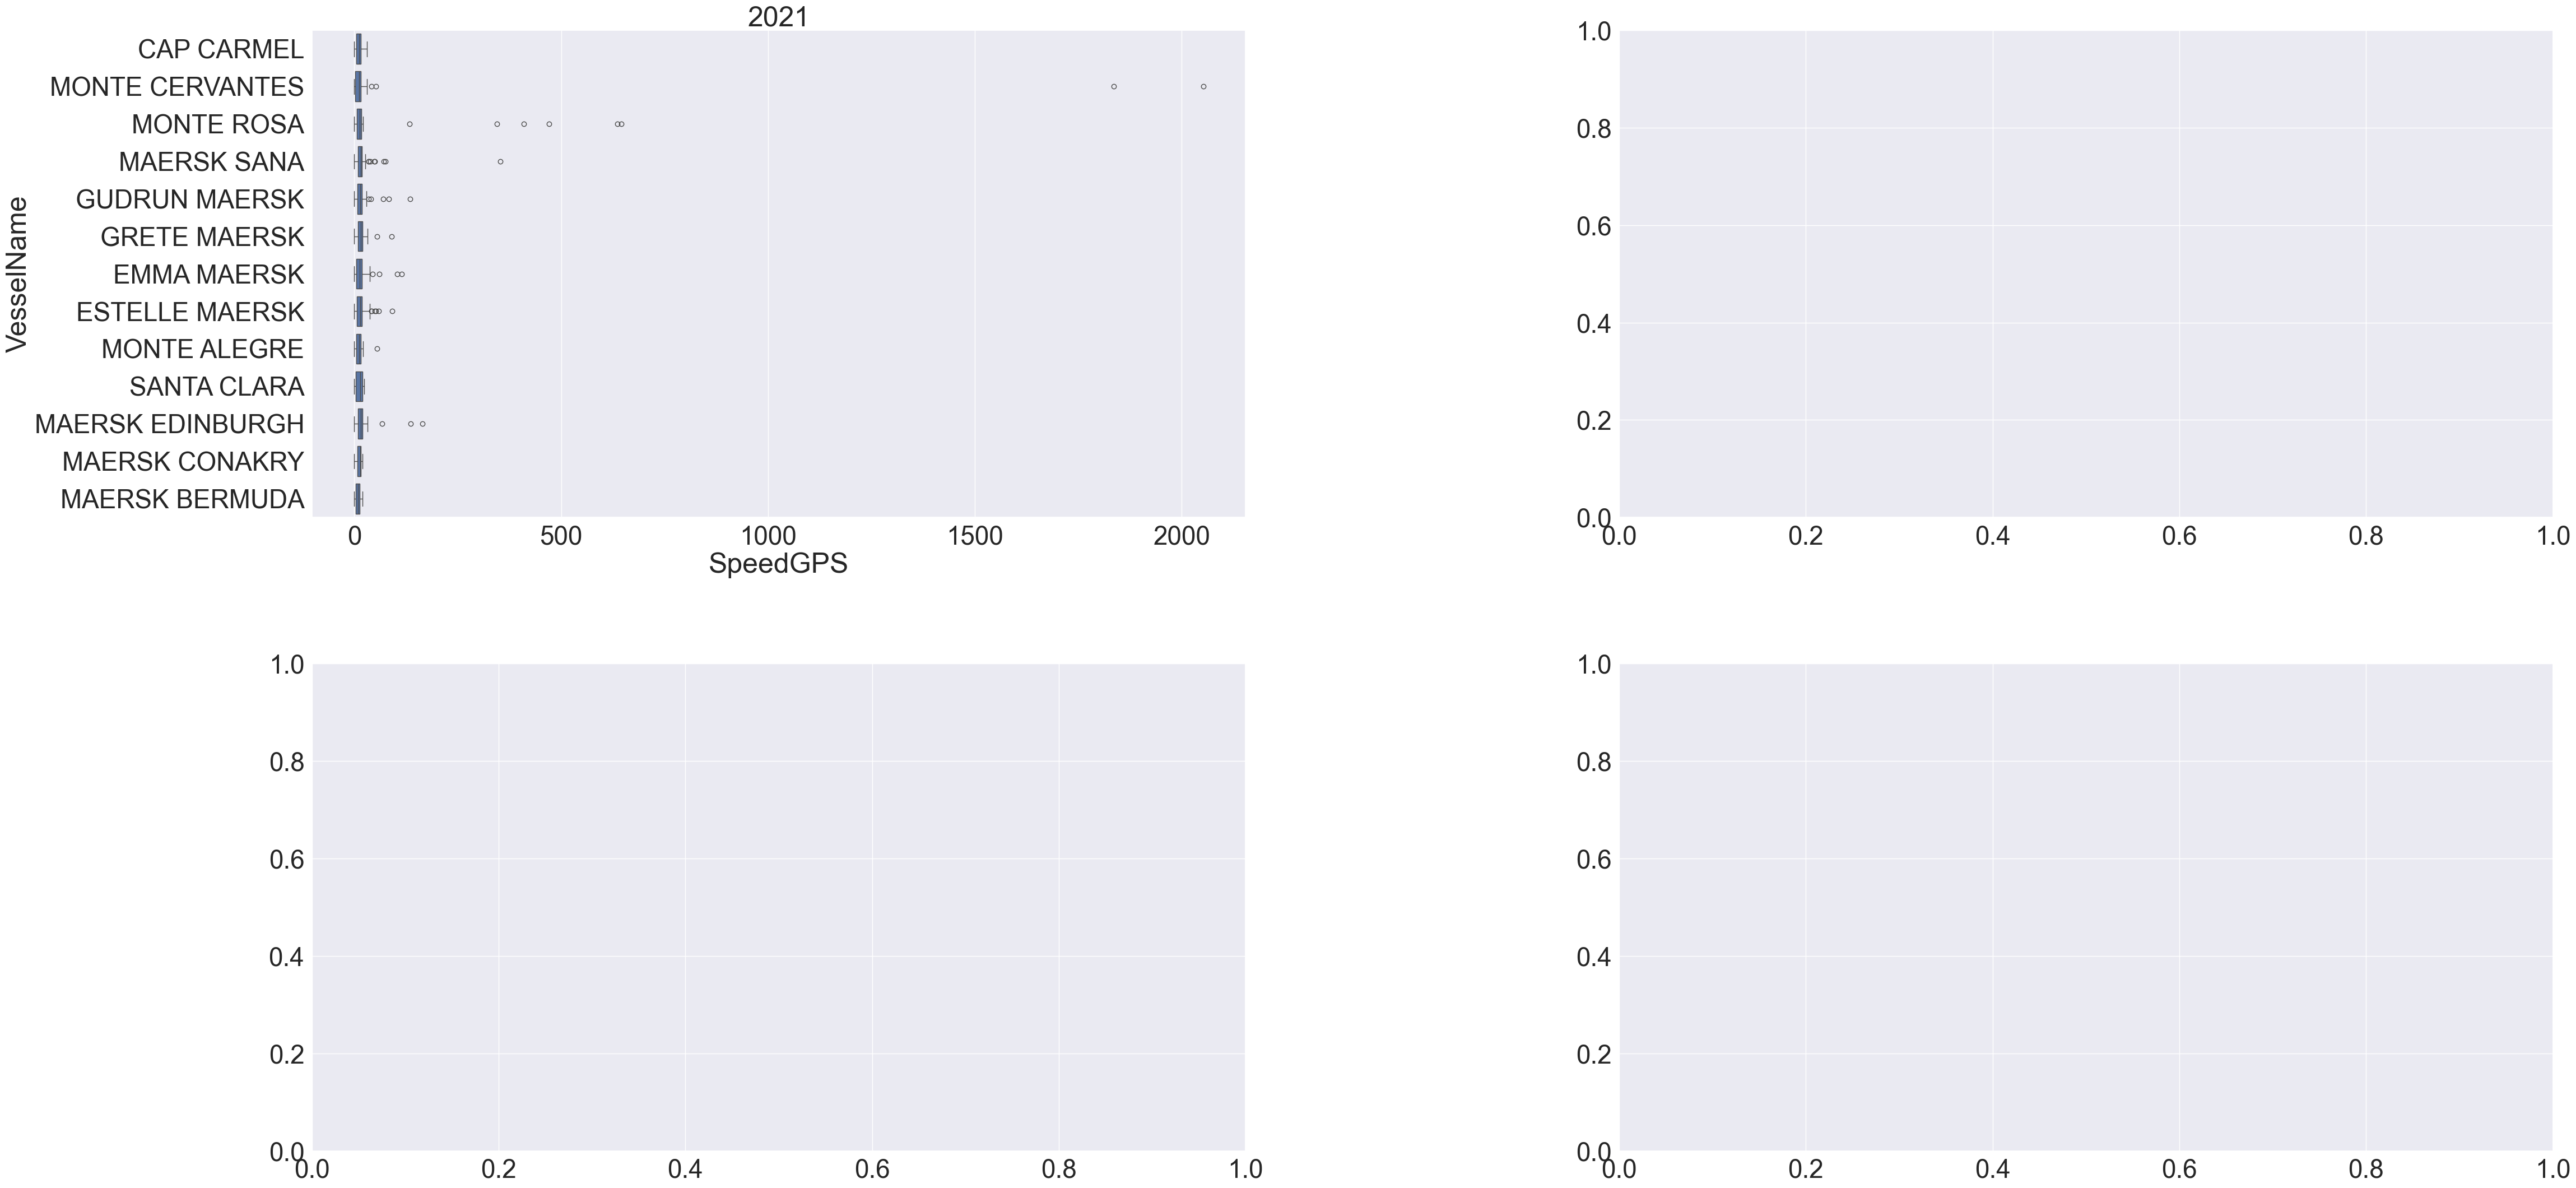

In [56]:
#ME1Power
fig, axes = plt.subplots(2, 2, figsize=(50, 25))

temp_2021 = data_2021.loc[data_2021['VesselName'].isin(ship_particulars['VesselName'])]

sns.boxplot(ax=axes[0, 0], data = temp_2021, x='ME1Power', y='VesselName').set(title='2021')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.3)

sns.set(font_scale=3)

#Speed
fig, axes = plt.subplots(2, 2, figsize=(50, 25))
sns.boxplot(ax=axes[0, 0], data = temp_2021, x='SpeedGPS', y='VesselName').set(title='2021')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.3)

sns.set(font_scale=3)


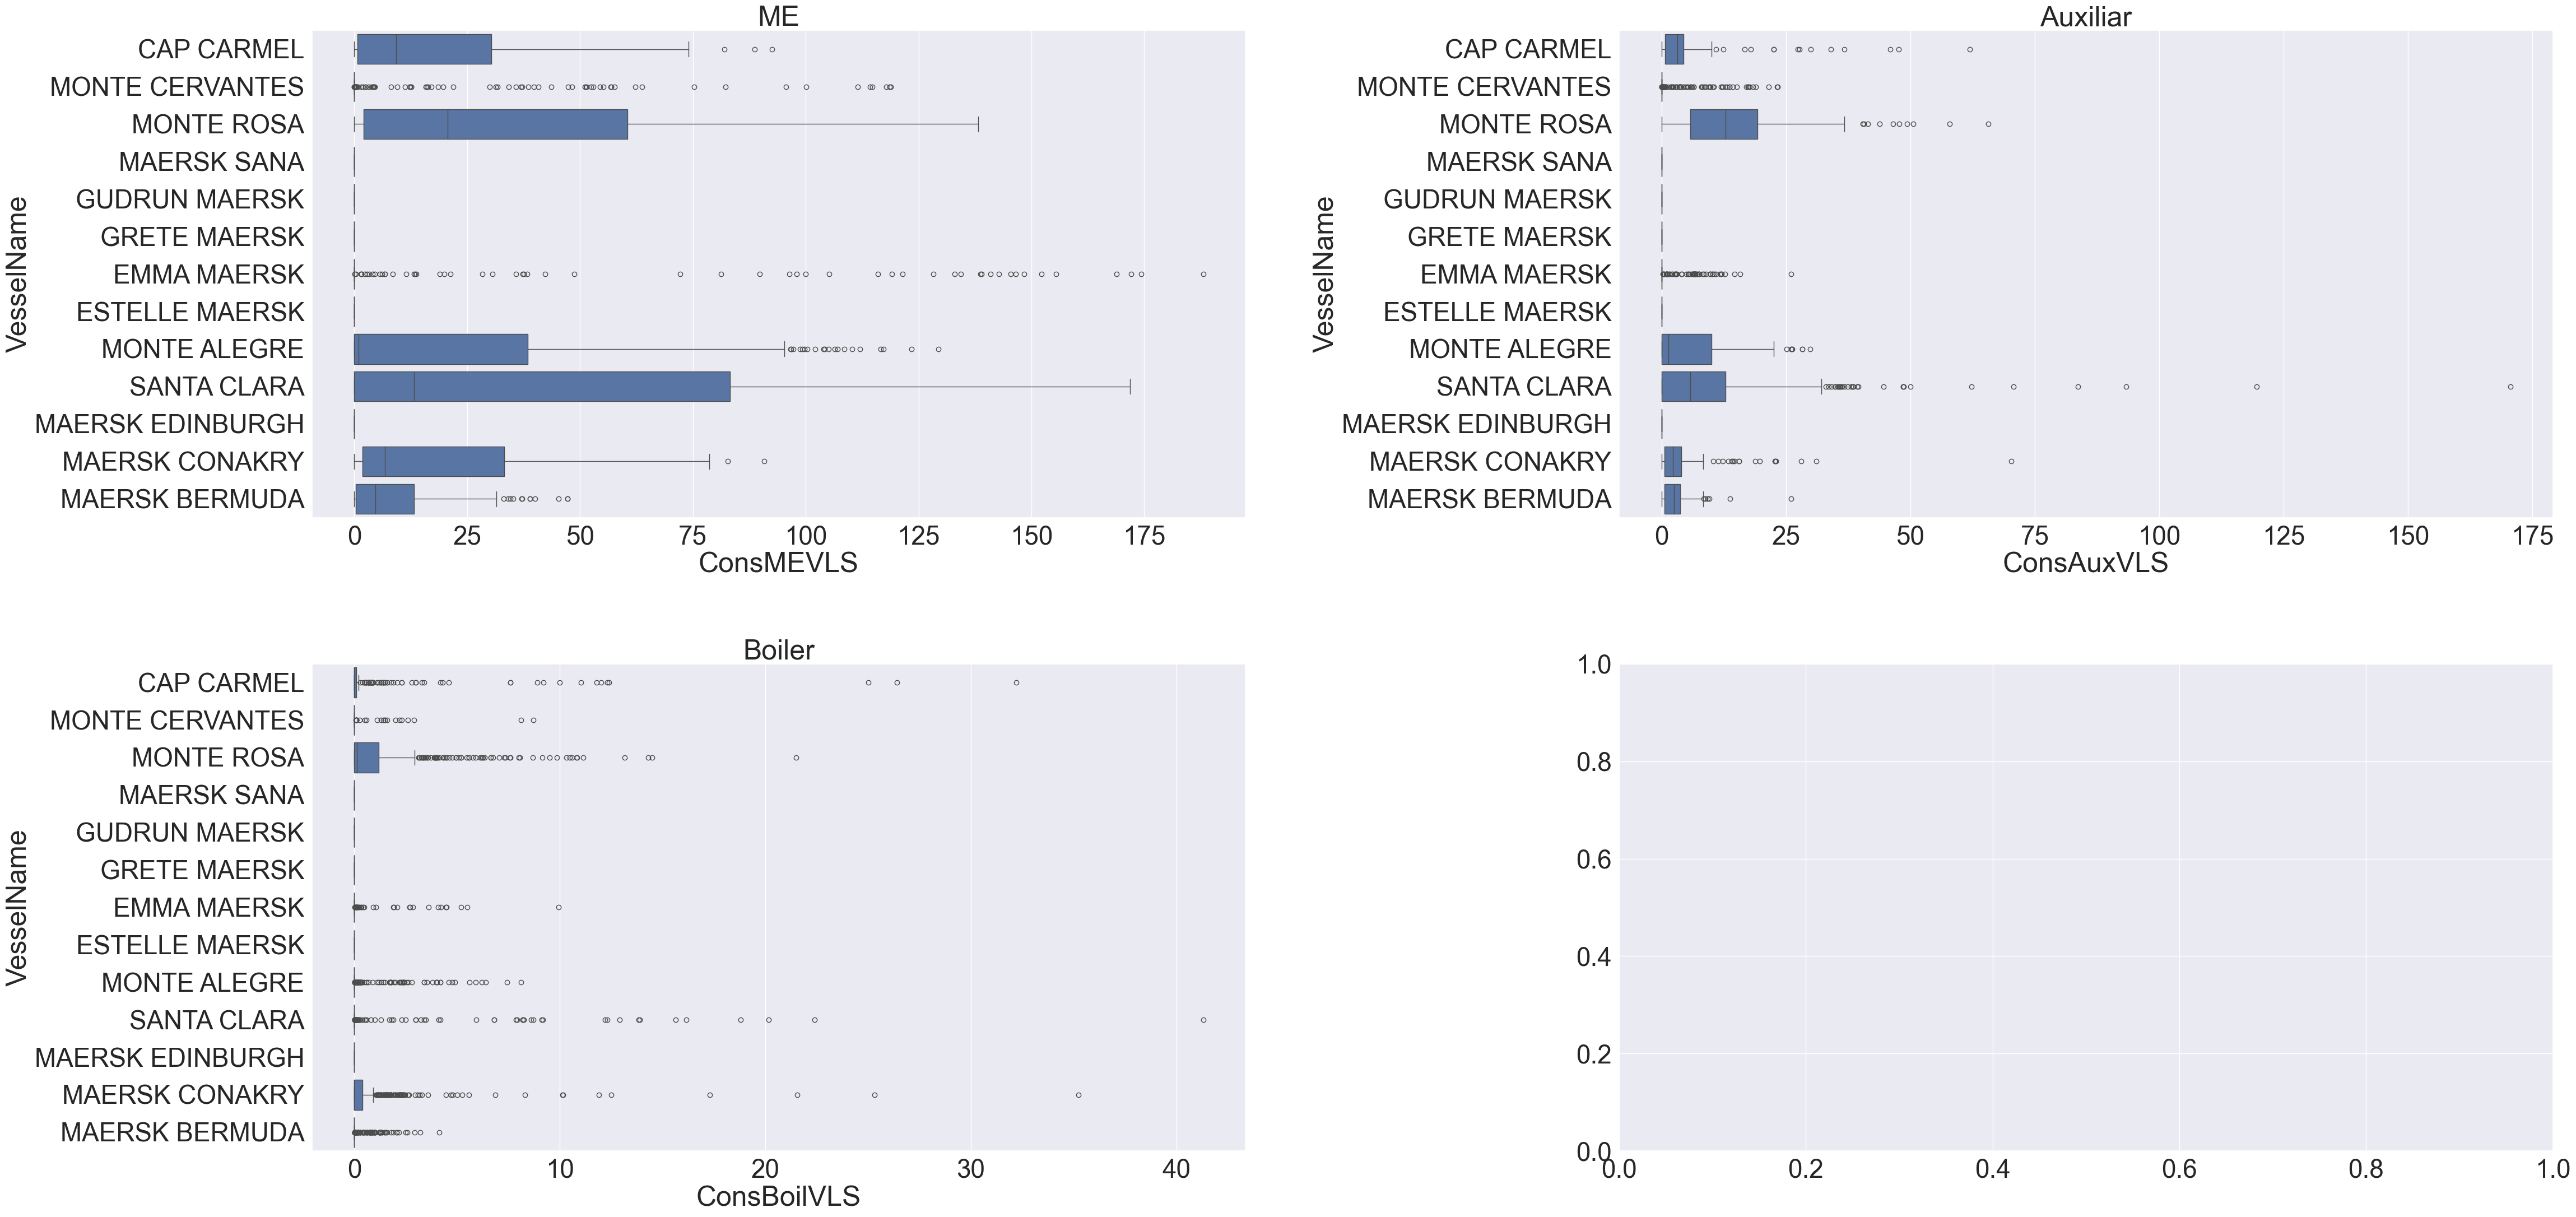

In [57]:
#Fuel Consumption (Main, Auxiliar Boiler )
fig, axes = plt.subplots(2, 2, figsize=(50, 25))

temp_2021 = data_2021.loc[data_2021['VesselName'].isin(ship_particulars['VesselName'])]

sns.boxplot(ax=axes[0, 0], data = temp_2021, x='ConsMEVLS', y='VesselName').set(title='ME')
sns.boxplot(ax=axes[0, 1], data = temp_2021, x='ConsAuxVLS', y='VesselName').set(title='Auxiliar')
sns.boxplot(ax=axes[1, 0], data = temp_2021, x='ConsBoilVLS', y='VesselName').set(title='Boiler')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.3)

sns.set(font_scale=3)

### Missing values for any attribute

In [58]:
#Check for any attribute - current: DistanceGPS

temp_2021 = [data_2021]
for d in temp_2021:
    df = d[['VesselName', 'DistanceGPS']]
    df = df.loc[df['VesselName'].isin(ship_particulars['VesselName'])]
    print(len(df[df.isna().any(axis=1)]))

data_all

0


,ImoNo,MLCode,VesselName,VoyageNo,VoyageStatus,DSC,VesselId,ReportId,ReportTypeId,ReportTypeName,ReportPeriodHrs,ClosingDateTime,FromPortCode,FromPortName,FromCountryCode,ToPortCode,ToPortName,ToCountryCode,Departure,BOSP,EOSP,Alongside,LastLine,BallastWater,DistanceGPS,SpeedGPS,AnchorageHrs,DriftingHrs,TimeAtSeaHours,DraughtFore,DraughtAft,AUXBlowerEnergy,AUX1Energy,AUX1RunHrs,AUX2Energy,AUX2RunHrs,AUX3Energy,AUX3RunHrs,AUX4Energy,AUX4RunHrs,AUX5Energy,AUX5RunHrs,ME1Power,ME1RPM,ME1RunHrs,ME2Power,ME2RPM,ME2RunHrs,NoOfReefers,ReeferPower,ReeferCoolerPumpPower,SG1Energy,SG1RunHrs,SG2Energy,SG2RunHrs,SM1Energy,SM1RunHrs,SM2Energy,SM2RunHrs,WHREnergy,WHRRunHrs,ConsMEHS,ConsMEULS,ConsMEVLS,ConsMEMDO,ConsAuxHS,ConsAuxULS,ConsAuxVLS,ConsAuxMDO,ConsBoilHS,ConsBoilULS,ConsBoilVLS,ConsBoilMDO,SulphurHS,SulphurVLS,SulphurULS,SulphurMDO,TEUReported,NoOf20Full,NoOf20Empty,NoOf40Full,NoOf40Empty,NoOf45Full,NoOf45Empty,NoOfOtherFull,NoOfOtherEmpty,NoOfOOG,NoOfReeferContainers,VerifiedGrossMassKG,WeightOf20Empty,WeightOf20Full,TotalWeightOf20,WeightOf40Empty,WeightOf40Full,TotalWeightOf40,WeightOf45Empty,WeightOf45Full,TotalWeightOf45,WeightOfOtherEmpty,WeightOfOtherFull,TotalWeightOfOther,WeightOfOOG,TotalWeightOfContainers,BunkerTimeForFuelUTC,BunkerHSLastLine,BunkerULSLastLine,BunkerVLSLastLine,BunkerMDOLastLine,StockTimeForFuelUTC,StockHSLastLine,StockVLSLastLine,StockULSLastLine,StockMDOLastLine,FleetGroup,FromPortCodeABS,ToPortCodeABS,ReportingYear,num_eu_ports,in_port,port_arrival,port_departure,EU_port_stay,fuel_cons_at_berth_HS,fuel_cons_at_berth_ULS,fuel_cons_at_berth_VLS,fuel_cons_at_berth_MDO,reefer_days,FuelEU_Related_HS_cons_ME,HS_consumption_ME,FuelEU_Related_HS_cons_Aux,HS_consumption_Aux,FuelEU_Related_HS_cons_Boil,HS_consumption_Boil,FuelEU_Related_ULS_cons_ME,ULS_consumption_ME,FuelEU_Related_ULS_cons_Aux,ULS_consumption_Aux,FuelEU_Related_ULS_cons_Boil,ULS_consumption_Boil,FuelEU_Related_VLS_cons_ME,VLS_consumption_ME,FuelEU_Related_VLS_cons_Aux,VLS_consumption_Aux,FuelEU_Related_VLS_cons_Boil,VLS_consumption_Boil,FuelEU_Related_MDO_cons_ME,MDO_consumption_ME,FuelEU_Related_MDO_cons_Aux,MDO_consumption_Aux,FuelEU_Related_MDO_cons_Boil,MDO_consumption_Boil,energy_at_berth,energy_at_berth_FuelEU,energy_at_berth_EU,ME_Emissions_wtt [tCO2eq],Aux_Emissions_wtt [tCO2eq],Boil_Emissions_wtt [tCO2eq],ME_Emissions_ttw [tCO2eq],Aux_Emissions_ttw [tCO2eq],Boil_Emissions_ttw [tCO2eq],ME_Emissions_wtw [tCO2eq],Aux_Emissions_wtw [tCO2eq],Boil_Emissions_wtw [tCO2eq],Total CO2 Emissions [tCO2eq]
0,9064384,165,MAERSK TAASINGE,2031,0,12284300,188,4393078,3,DEPARTURE,4.200000,2020-12-23 01:30:00,DLA,DOUALA,CM,PNR,POINTE NOIRE,CG,2020-12-22 21:18:00,2020-12-23 01:30:00,2020-12-25 12:00:00,2021-01-04 14:18:00,2021-01-06 15:24:00,0.0,25.0,5.952381,0.0,0.000000,4.200000,8.3,8.3,193.0,990.0,3.8,650.0,2.400000,110,0.400000,0.0,0.0,0,0.0,0,51.9,4.200000,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,1.05,0.0,0.0,0.0,0.42,0.0,0.0,0.0,0.00,0.0,0.0,0.47,0.0,0.0,0,215,0,386,39,0,0,0,0,0,0,15033548,0,2580,2580,156,9264,9420,0.0,0,0.0,0,0,0,0,12000.0,0,0.0,0.0,0.0,0.0,2020-12-22 21:18:00,0.0,396.25,0.0,34.75,0.0,CMDLA,CGPNR,2020,0.0,False,False,True,False,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.05,0.0,0.42,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.568260,0.227304,0.000000,0.135651,0.054260,0.000000,0.703911,0.281564,0.000000,0.985475
1,9064384,165,MAERSK TAASINGE,2031,0,0,188,4393754,0,SEA,31.500000,2020-12-24 09:00:00,DLA,DOUALA,CM,PNR,POINTE NOIRE,CG,2020-12-22 21:18:00,2020-12-23 01:30:00,2020-12-25 12:00:00,2021-01-04 14:18:00,2021-01-06 15:24:00,610.0,319.0,10.126984,0.0,0.000000,31.500000,8.3,8.3,1459.0,330.0,0.9,12990.0,31.500000,0,0.000000,0.0,0.0,0,0.0,2966,75.6,31.500000,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,17.60,0.0,0.0,0.0,3.24,0.0,0.0,0.0,0.00,0.0,0.0,0.47,0.0,0.0,0,215,0,386,39,0,0,0,0,0,0,15033548,0,2580,2580,156,9264,9420,0.0,0,0.0,0,0,0,0,12000.0,0,0.0,0.0,

## FuelEU


In [59]:
data_all_FuelEU = data_all.merge(ship_particulars, on="VesselName") #merge the ships particulars so we only have the ships we want

#Lower Calorific Value (MJ / g)
LCV_HFO = 0.0405    
LCV_LFO = 0.041
LCV_MDO = 0.0427

#Wake to Tank(WtT) factors (gCO2eq / MJ)
wtt_ghg_HFO = 13.5
wtt_ghg_LFO = 13.2
wtt_ghg_MDO = 14.4

C_f_CO2_HFO = 3.114
C_f_CO2_LFO = 3.151
C_f_CO2_MDO = 3.206

GWP_CO2 = 1

#Tank to Whell (TtW) factors (gCO2eq / MJ)
ttw_ghg_HFO = C_f_CO2_HFO * GWP_CO2
ttw_ghg_LFO = C_f_CO2_LFO * GWP_CO2
ttw_ghg_MDO = C_f_CO2_MDO * GWP_CO2

C_slip_HFO = 0
C_slip_LFO = 0
C_slip_MDO = 0


#Emissions for all years
#take all engines into account (total consumption over e.g. all auxiliary engines)
engines = ["ME","Aux","Boil"]

def FuelEUcalc(data): #FuelEUprep know already how much to account for Fuel EU depending on how many EU ports are involved
    fuels = ['HS', 'ULS', 'VLS', 'MDO']
    data_output = data.groupby(['VesselName', 'ReportingYear']).agg({'FuelEU_Related_HS_cons_ME' : 'sum', 'FuelEU_Related_VLS_cons_ME' : 'sum', 'FuelEU_Related_ULS_cons_ME' : 'sum', 'FuelEU_Related_MDO_cons_ME' : 'sum',
                                                                        'FuelEU_Related_HS_cons_Aux' : 'sum', 'FuelEU_Related_VLS_cons_Aux' : 'sum', 'FuelEU_Related_ULS_cons_Aux' : 'sum', 'FuelEU_Related_MDO_cons_Aux' : 'sum',
                                                                        'FuelEU_Related_HS_cons_Boil' : 'sum', 'FuelEU_Related_VLS_cons_Boil' : 'sum', 'FuelEU_Related_ULS_cons_Boil' : 'sum', 'FuelEU_Related_MDO_cons_Boil' : 'sum'})
    
    data_output = data_output.reset_index()

    for fuel in fuels:
        data_output['FuelEU_Related_{}_cons_ME'.format(fuel)] = data_output['FuelEU_Related_{}_cons_ME'.format(fuel)]*1000000 #from t to g
        data_output['FuelEU_Related_{}_cons_Aux'.format(fuel)] = data_output['FuelEU_Related_{}_cons_Aux'.format(fuel)]*1000000 #from t to g
        data_output['FuelEU_Related_{}_cons_Boil'.format(fuel)] = data_output['FuelEU_Related_{}_cons_Boil'.format(fuel)]*1000000 #from t to g

    #nergy needed to oxidise 
    #For ME
    data_output['FuelEU Energy required to oxidise in ME [MJ]'] = data_output['FuelEU_Related_HS_cons_ME']*LCV_HFO + data_output['FuelEU_Related_VLS_cons_ME']*LCV_LFO + data_output['FuelEU_Related_ULS_cons_ME']*LCV_LFO + data_output['FuelEU_Related_MDO_cons_ME']*LCV_MDO
    #For Aux
    data_output['FuelEU Energy required to oxidise in Aux [MJ]'] = data_output['FuelEU_Related_HS_cons_Aux']*LCV_HFO + data_output['FuelEU_Related_VLS_cons_Aux']*LCV_LFO + data_output['FuelEU_Related_ULS_cons_Aux']*LCV_LFO + data_output['FuelEU_Related_MDO_cons_Aux']*LCV_MDO
    #For Boiler
    data_output['FuelEU Energy required to oxidise in Boil [MJ]'] = data_output['FuelEU_Related_HS_cons_Boil']*LCV_HFO + data_output['FuelEU_Related_VLS_cons_Boil']*LCV_LFO + data_output['FuelEU_Related_ULS_cons_Boil']*LCV_LFO + data_output['FuelEU_Related_MDO_cons_Boil']*LCV_MDO

        
    for engine in engines:
        data_output[f"FuelEU_{engine}_Emissions_wtt [gCO2eq]"] = data_output[f'FuelEU_Related_HS_cons_{engine}']*LCV_HFO*wtt_ghg_HFO + data_output[f'FuelEU_Related_VLS_cons_{engine}']*LCV_LFO*wtt_ghg_LFO + data_output[f'FuelEU_Related_ULS_cons_{engine}']*LCV_LFO*wtt_ghg_LFO + data_output[f'FuelEU_Related_MDO_cons_{engine}']*LCV_MDO*wtt_ghg_MDO
        data_output[f"FuelEU_{engine}_Emissions_ttw [gCO2eq]"] = data_output[f'FuelEU_Related_HS_cons_{engine}']*(1-(C_slip_HFO/100))*ttw_ghg_HFO + data_output[f'FuelEU_Related_VLS_cons_{engine}']*(1-(C_slip_LFO))*ttw_ghg_LFO + data_output[f'FuelEU_Related_ULS_cons_{engine}']*(1-(C_slip_LFO))*ttw_ghg_LFO + data_output[f'FuelEU_Related_MDO_cons_{engine}']*(1-(C_slip_MDO))*ttw_ghg_MDO
    
    data_output["FuelEU_total_wtt [gCO2eq / MJ]"] = (data_output["FuelEU_ME_Emissions_wtt [gCO2eq]"] + data_output["FuelEU_Aux_Emissions_wtt [gCO2eq]"] + data_output["FuelEU_Boil_Emissions_wtt [gCO2eq]"]) / (data_output['FuelEU Energy required to oxidise in ME [MJ]'] + data_output['FuelEU Energy required to oxidise in Aux [MJ]'] + data_output['FuelEU Energy required to oxidise in Boil [MJ]']) 
    data_output["FuelEU_total_ttw [gCO2eq / MJ]"] = (data_output["FuelEU_ME_Emissions_ttw [gCO2eq]"] + data_output["FuelEU_Aux_Emissions_ttw [gCO2eq]"] + data_output["FuelEU_Boil_Emissions_ttw [gCO2eq]"]) / (data_output['FuelEU Energy required to oxidise in ME [MJ]'] + data_output['FuelEU Energy required to oxidise in Aux [MJ]'] + data_output['FuelEU Energy required to oxidise in Boil [MJ]']) 

    data_output["FuelEU_total_wtw [gCO2eq / MJ]"] = data_output["FuelEU_total_wtt [gCO2eq / MJ]"] + data_output["FuelEU_total_ttw [gCO2eq / MJ]"]

    return data_output

FuelEU_output = FuelEUcalc(data_all_FuelEU)
output_file = 'FuelEU_results_MG_MGF_GS.xlsx'
FuelEU_output.to_excel(output_file, index=False)

print("Results successfully saved to processed_results.xlsx")

FuelEU_output

Results successfully saved to processed_results.xlsx


,VesselName,ReportingYear,FuelEU_Related_HS_cons_ME,FuelEU_Related_VLS_cons_ME,FuelEU_Related_ULS_cons_ME,FuelEU_Related_MDO_cons_ME,FuelEU_Related_HS_cons_Aux,FuelEU_Related_VLS_cons_Aux,FuelEU_Related_ULS_cons_Aux,FuelEU_Related_MDO_cons_Aux,FuelEU_Related_HS_cons_Boil,FuelEU_Related_VLS_cons_Boil,FuelEU_Related_ULS_cons_Boil,FuelEU_Related_MDO_cons_Boil,FuelEU Energy required to oxidise in ME [MJ],FuelEU Energy required to oxidise in Aux [MJ],FuelEU Energy required to oxidise in Boil [MJ],FuelEU_ME_Emissions_wtt [gCO2eq],FuelEU_ME_Emissions_ttw [gCO2eq],FuelEU_Aux_Emissions_wtt [gCO2eq],FuelEU_Aux_Emissions_ttw [gCO2eq],FuelEU_Boil_Emissions_wtt [gCO2eq],FuelEU_Boil_Emissions_ttw [gCO2eq],FuelEU_total_wtt [gCO2eq / MJ],FuelEU_total_ttw [gCO2eq / MJ],FuelEU_total_wtw [gCO2eq / MJ]
0,CAP CARMEL,2020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN
1,CAP CARMEL,2021,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN
2,EMMA MAERSK,2020,0.000000e+00,0.000000e+00,4.322000e+07,0.000000e+00,0.0,0.000000e+00,42860000.0,7.000000e+04,0.0,0.0,11800000.0,0.0,1772020.0,1760249.0,483800.0,2.339066e+07,1.361862e+08,2.323887e+07,1.352763e+08,6386160.0,3.718180e+07,13.200893,76.852340,90.053233
3,EMMA MAERSK,2021,1.083535e+09,7.118000e+07,1.369950e+08,1.731700e+08,240150000.0,3.037000e+07,176185000.0,2.127850e+08,0.0,9490000.0,60405000.0,55110000.0,59812701.5,27280749.5,5218892.0,8.115658e+08,4.585270e+09,3.739268e+08,2.080871e+09,71713210.8,3.969218e+08,13.619044,76.512659,90.131703
4,ESTELLE MAERSK,2020,0.000000e+00,0.000000e+00,4.780000e+07,0.000000e+00,0.0,0.000000e+00,23750000.0,0.000000e+00,0.0,0.0,6515000.0,0.0,1959800.0,973750.0,267115.0,2.586936e+07,1.506178e+08,1.285350e+07,7.483625e+07,3525918.0,2.052876e+07,13.200000,76.853659,90.053659
5,ESTELLE MAERSK,2021,5.485450e+08,0.000000e+00,4.576850e+08,0.000000e+00,142930000.0,0.000000e+00,375125000.0,0.000000e+00,0.0,0.0,86220000.0,0.0,40981157.5,21168790.0,3535020.0,5.476161e+08,3.150335e+09,2.811646e+08,1.627103e+09,46662264.0,2.716792e+08,13.327905,76.868679,90.196584
6,GRETE MAERSK,2020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN
7,GRETE MAERSK,2021,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN
8,GUDRUN MAERSK,2020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN
9,GUDRUN MAERSK,2021,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN


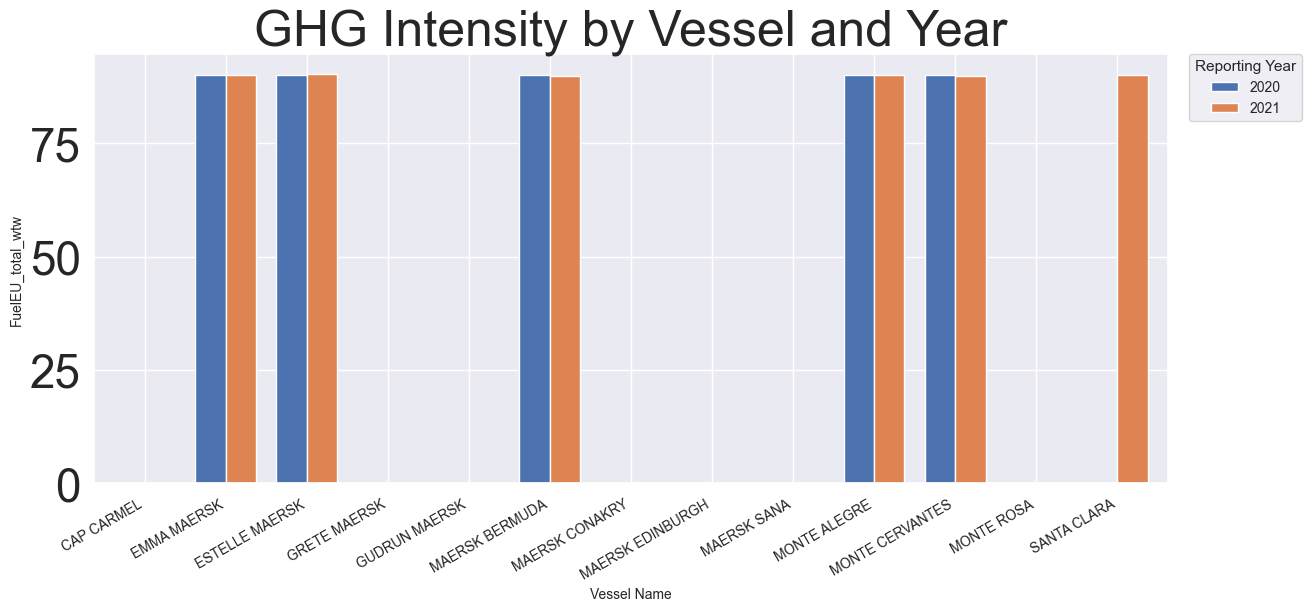

In [60]:
# pivot so we have years as columns and vessel names as index
pivot = FuelEU_output.pivot_table(
    index="VesselName",
    columns="ReportingYear",
    values="FuelEU_total_wtw [gCO2eq / MJ]",
    aggfunc="sum",  # or "mean" if you want average per year
).fillna(0)

# ensure years are sorted
pivot = pivot.sort_index(axis=1)

# plot
pivot.plot(
    kind="bar",
    figsize=(14, 7),
    width=0.75
)

plt.title("GHG Intensity by Vessel and Year")
plt.xlabel("Vessel Name", fontsize=10)
plt.ylabel("FuelEU_total_wtw", fontsize=10)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.legend(title="Reporting Year", fontsize=10, title_fontsize=11, loc="upper left",
    bbox_to_anchor=(1.02, 1),   # moves it just outside the plot area
    borderaxespad=0)
plt.tight_layout()
plt.show()

### Compare with GHG intensity

In [61]:


data_comp = pd.DataFrame()

#get GHG intensity value from all settings (this is the dataframe where we add the compliance balance to)
data_comp[['VesselName', 'ReportingYear','GHG intensity [gCO2eq / MJ]']] = FuelEU_output[['VesselName', 'ReportingYear',"FuelEU_total_wtw [gCO2eq / MJ]"]]
data_comp['Total energy'] = (FuelEU_output['FuelEU Energy required to oxidise in ME [MJ]']+FuelEU_output['FuelEU Energy required to oxidise in Aux [MJ]'] + FuelEU_output['FuelEU Energy required to oxidise in Boil [MJ]']) #Add new column with the total energy
data_comp['GHG intensity [gCO2eq]'] = data_comp['GHG intensity [gCO2eq / MJ]']*data_comp['Total energy'] #Column for gross ammount of GHG intensity (in grams)

#set reference value in accordance with world fleet (FuelEU Maritime and EU ETS Sound incentives for the fuel choice?)
#Does that need an update?
#updated from 90.98 as of FuelEU regulation Article 4.2

data_comp['ghg_reference_value'] = 91.16

#reduced Ghg reference value per year (2% reduction in 2025) in accordance with fuel eu regulation Art 4.2
#Update with Fuel EU regulation EU Commission 2023 R1805
compliance_balance = {2020: 1.00, 2025 : 0.98, 2030 : 0.94, 2035 : 0.855, 2040 : 0.69, 2045 : 0.38, 2050: 0.20}



for x in compliance_balance.keys():
    data_comp['{}_ghg_referece_value'.format(x)] = data_comp['ghg_reference_value']*compliance_balance[x]
    data_comp['{} compliance balance [gCO2eq/MJ]'.format(x)] = (data_comp['ghg_reference_value']*compliance_balance[x] - data_comp['GHG intensity [gCO2eq / MJ]'])
    data_comp['{} compliance balance [gCO2eq]'.format(x)] = ((data_comp['ghg_reference_value']*compliance_balance[x]) - (data_comp['GHG intensity [gCO2eq / MJ]']))*data_comp['Total energy']
    #no penalty if compliance balance is positive
    data_comp.loc[(data_comp['{} compliance balance [gCO2eq]'.format(x)] >= 0), '{} Penalty'.format(x)] = 0

    #if negative, pay penalty of compliance balance devided by ghg intensity times 41 times 2400EUR
    data_comp.loc[(data_comp['{} compliance balance [gCO2eq]'.format(x)] < 0), '{} Penalty'.format(x)] = ((data_comp['{} compliance balance [gCO2eq]'.format(x)]*(-1))/(data_comp['GHG intensity [gCO2eq / MJ]']*41000))*2400

data_comp.loc[(data_comp['ReportingYear']==2021)]

,VesselName,ReportingYear,GHG intensity [gCO2eq / MJ],Total energy,GHG intensity [gCO2eq],ghg_reference_value,2020_ghg_referece_value,2020 compliance balance [gCO2eq/MJ],2020 compliance balance [gCO2eq],2020 Penalty,2025_ghg_referece_value,2025 compliance balance [gCO2eq/MJ],2025 compliance balance [gCO2eq],2025 Penalty,2030_ghg_referece_value,2030 compliance balance [gCO2eq/MJ],2030 compliance balance [gCO2eq],2030 Penalty,2035_ghg_referece_value,2035 compliance balance [gCO2eq/MJ],2035 compliance balance [gCO2eq],2035 Penalty,2040_ghg_referece_value,2040 compliance balance [gCO2eq/MJ],2040 compliance balance [gCO2eq],2040 Penalty,2045_ghg_referece_value,2045 compliance balance [gCO2eq/MJ],2045 compliance balance [gCO2eq],2045 Penalty,2050_ghg_referece_value,2050 compliance balance [gCO2eq/MJ],2050 compliance balance [gCO2eq],2050 Penalty
1,CAP CARMEL,2021,NaN,0.0,NaN,91.16,91.16,NaN,NaN,NaN,89.3368,NaN,NaN,NaN,85.6904,NaN,NaN,NaN,77.9418,NaN,NaN,NaN,62.9004,NaN,NaN,NaN,34.6408,NaN,NaN,NaN,18.232,NaN,NaN,NaN
3,EMMA MAERSK,2021,90.131703,92312343.0,8.320269e+09,91.16,91.16,1.028297,9.492446e+07,0.0,89.3368,-0.794903,-7.337940e+07,47656.700737,85.6904,-4.441303,-4.099871e+08,2.662686e+05,77.9418,-12.189903,-1.125279e+09,7.308190e+05,62.9004,-27.231303,-2.513785e+09,1.632593e+06,34.6408,-55.490903,-5.122495e+09,3.326836e+06,18.232,-71.899703,-6.637230e+09,4.310590e+06
5,ESTELLE MAERSK,2021,90.196584,65684967.5,5.924560e+09,91.16,91.16,0.963416,6.328197e+07,0.0,89.3368,-0.859784,-5.647487e+07,36651.564577,85.6904,-4.506184,-2.959885e+08,1.920933e+05,77.9418,-12.254784,-8.049551e+08,5.224069e+05,62.9004,-27.296184,-1.792949e+09,1.163604e+06,34.6408,-55.555784,-3.649180e+09,2.368277e+06,18.232,-71.964584,-4.726991e+09,3.067765e+06
7,GRETE MAERSK,2021,NaN,0.0,NaN,91.16,91.16,NaN,NaN,NaN,89.3368,NaN,NaN,NaN,85.6904,NaN,NaN,NaN,77.9418,NaN,NaN,NaN,62.9004,NaN,NaN,NaN,34.6408,NaN,NaN,NaN,18.232,NaN,NaN,NaN
9,GUDRUN MAERSK,2021,NaN,0.0,NaN,91.16,91.16,NaN,NaN,NaN,89.3368,NaN,NaN,NaN,85.6904,NaN,NaN,NaN,77.9418,NaN,NaN,NaN,62.9004,NaN,NaN,NaN,34.6408,NaN,NaN,NaN,18.232,NaN,NaN,NaN
11,MAERSK BERMUDA,2021,89.896290,10912016.5,9.809498e+08,91.16,91.16,1.263710,1.378962e+07,0.0,89.3368,-0.559490,-6.105165e+06,3975.419993,85.6904,-4.205890,-4.589474e+07,2.988468e+04,77.9418,-11.954490,-1.304476e+08,8.494184e+04,62.9004,-26.995890,-2.945796e+08,1.918175e+05,34.6408,-55.255490,-6.029488e+08,3.926143e+05,18.232,-71.664290,-7.820019e+08,5.092059e+05
13,MAERSK CONAKRY,2021,NaN,0.0,NaN,91.16,91.16,NaN,NaN,NaN,89.3368,NaN,NaN,NaN,85.6904,NaN,NaN,NaN,77.9418,NaN,NaN,NaN,62.9004,NaN,NaN,NaN,34.6408,NaN,NaN,NaN,18.232,NaN,NaN,NaN
15,MAERSK EDINBURGH,2021,NaN,0.0,NaN,91.16,91.16,NaN,NaN,NaN,89.3368,NaN,NaN,NaN,85.6904,NaN,NaN,NaN,77.9418,NaN,NaN,NaN,62.9004,NaN,NaN,NaN,34.6408,NaN,NaN,NaN,18.232,NaN,NaN,NaN
17,MAERSK SANA,2021,NaN,0.0,NaN,91.16,91.16,NaN,NaN,NaN,89.3368,NaN,NaN,NaN,85.6904,NaN,NaN,NaN,77.9418,NaN,NaN,NaN,62.9004,NaN,NaN,NaN,34.6408,NaN,NaN,NaN,18.232,NaN,NaN,NaN
19,MONTE ALEGRE,2021,90.030380,344583863.0,3.102302e+10,91.16,91.16,1.129620,3.892487e+08,0.0,89.3368,-0.693580,-2.389966e+08,155392.489605,85.6904,-4.339980,-1.495487e+09,9.723464e+05,77.9418,-12.088580,-4.165530e+09,2.708373e+06,62.9004,-27.129980,-9.348553e+09,6.078308e+06,34.6408,-55.389580,-1.908636e+10,1.240970e+07,18.232,-71.798380,-2.474056e+10,1.608599e+07


### Plot GHG intensity and compliance targets

   Year  GHG Reference Value
0  2020              91.1600
1  2025              89.3368
2  2030              85.6904
3  2035              77.9418
4  2040              62.9004
5  2045              34.6408
6  2050              18.2320


C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\23528968.py:69: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\23528968.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\MVA249\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


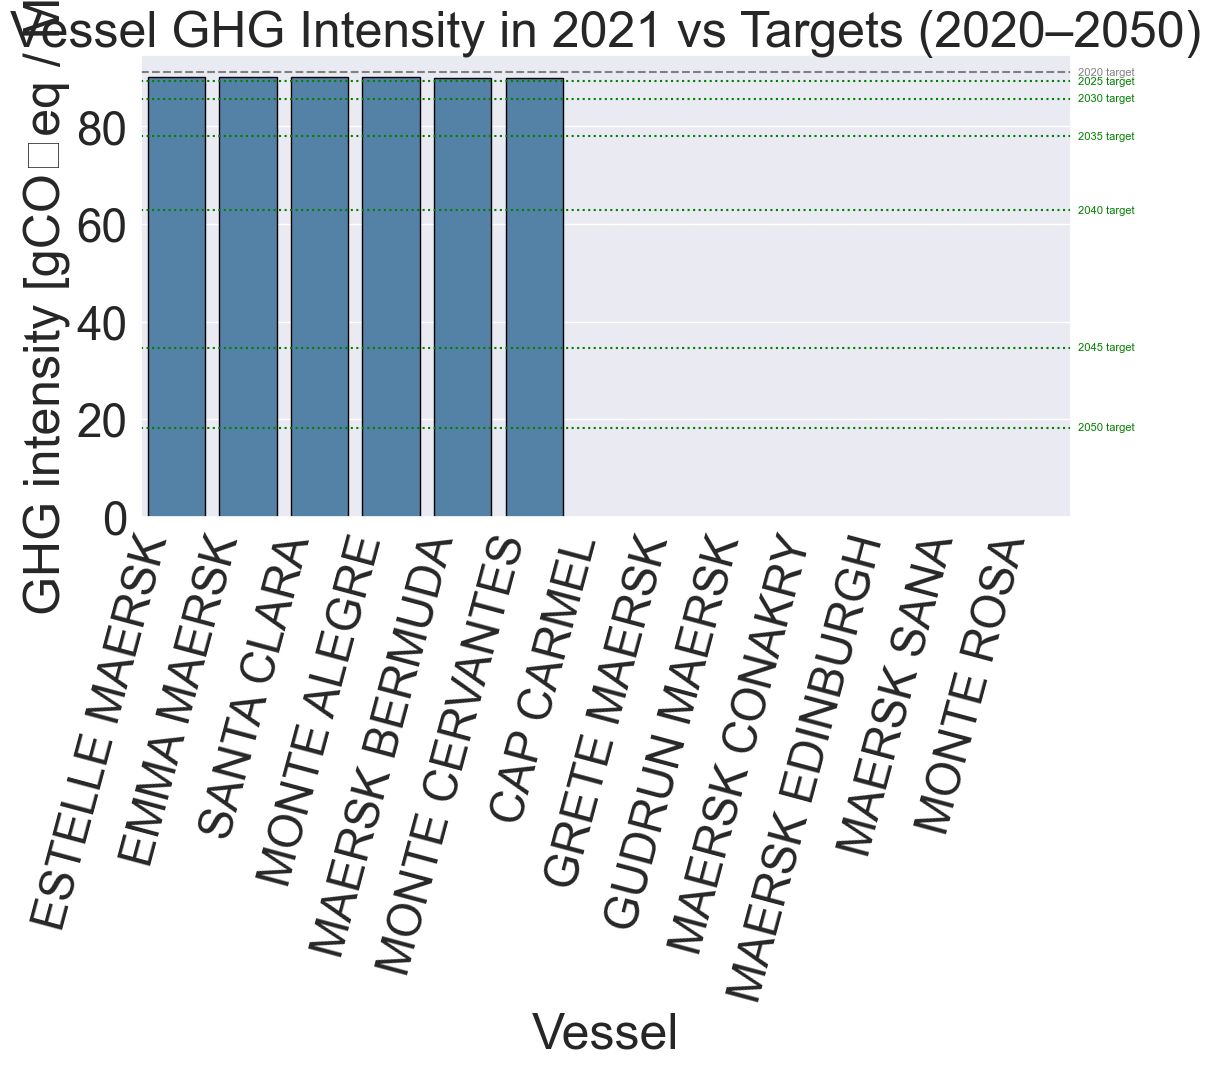

In [62]:
# Filter for one reporting year (e.g., 2021)
year = 2021
penalty_year = 2025

df_year = data_comp.loc[data_comp['ReportingYear'] == year].copy()

penalties_2025 = (data_comp.loc[data_comp['ReportingYear'] == penalty_year, ['VesselName', '2025_ghg_referece_value']].set_index('VesselName'))

df_year = df_year.merge(penalties_2025, on='VesselName', how='left')

# Get target for that year
df_target = pd.DataFrame()
df_target['Year'] = compliance_balance.keys()
df_target['GHG Reference Value'] = compliance_balance.values()
df_target['GHG Reference Value'] = df_target['GHG Reference Value'] * data_comp['ghg_reference_value']

print(df_target)
# Sort vessels by intensity
df_year = df_year.sort_values('GHG intensity [gCO2eq / MJ]', ascending=False)

plt.figure(figsize=(12, 6))

# --- Barplot: GHG intensity of each vessel in the chosen year ---
sns.barplot(
    data=df_year,
    x='VesselName',
    y='GHG intensity [gCO2eq / MJ]',
    color='steelblue',
    edgecolor='black'
)

# --- Overlay ALL target lines (2020–2050, every 5 years) ---
# Filter targets in that range
df_targets_plot = df_target[(df_target['Year'] >= 2020) &
                            (df_target['Year'] <= 2050)]

for _, row in df_targets_plot.iterrows():
    t_year = int(row['Year'])
    t_val  = row['GHG Reference Value']

    # choose a lighter/darker style depending on how far in the future it is
    if t_year == year:
        style = {'color': 'red', 'linewidth': 2.5}
    elif t_year < year:
        style = {'color': 'grey', 'linewidth': 1.5, 'linestyle': '--'}
    else:
        style = {'color': 'green', 'linewidth': 1.5, 'linestyle': ':'}

    plt.axhline(
        t_val,
        **style
    )
    # label on the right side
    plt.text(
        x=len(df_year) - 0.4,  # near the last bar
        y=t_val,
        s=f'{t_year} target',
        va='center',
        ha='left',
        fontsize=8,
        color=style['color']
    )

# --- Formatting ---
plt.xticks(rotation=75, ha='right')
plt.ylabel('GHG intensity [gCO₂eq / MJ]')
plt.xlabel('Vessel')
plt.title(f'Vessel GHG Intensity in {year} vs Targets (2020–2050)')
plt.tight_layout()
plt.show()


C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\1495443643.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


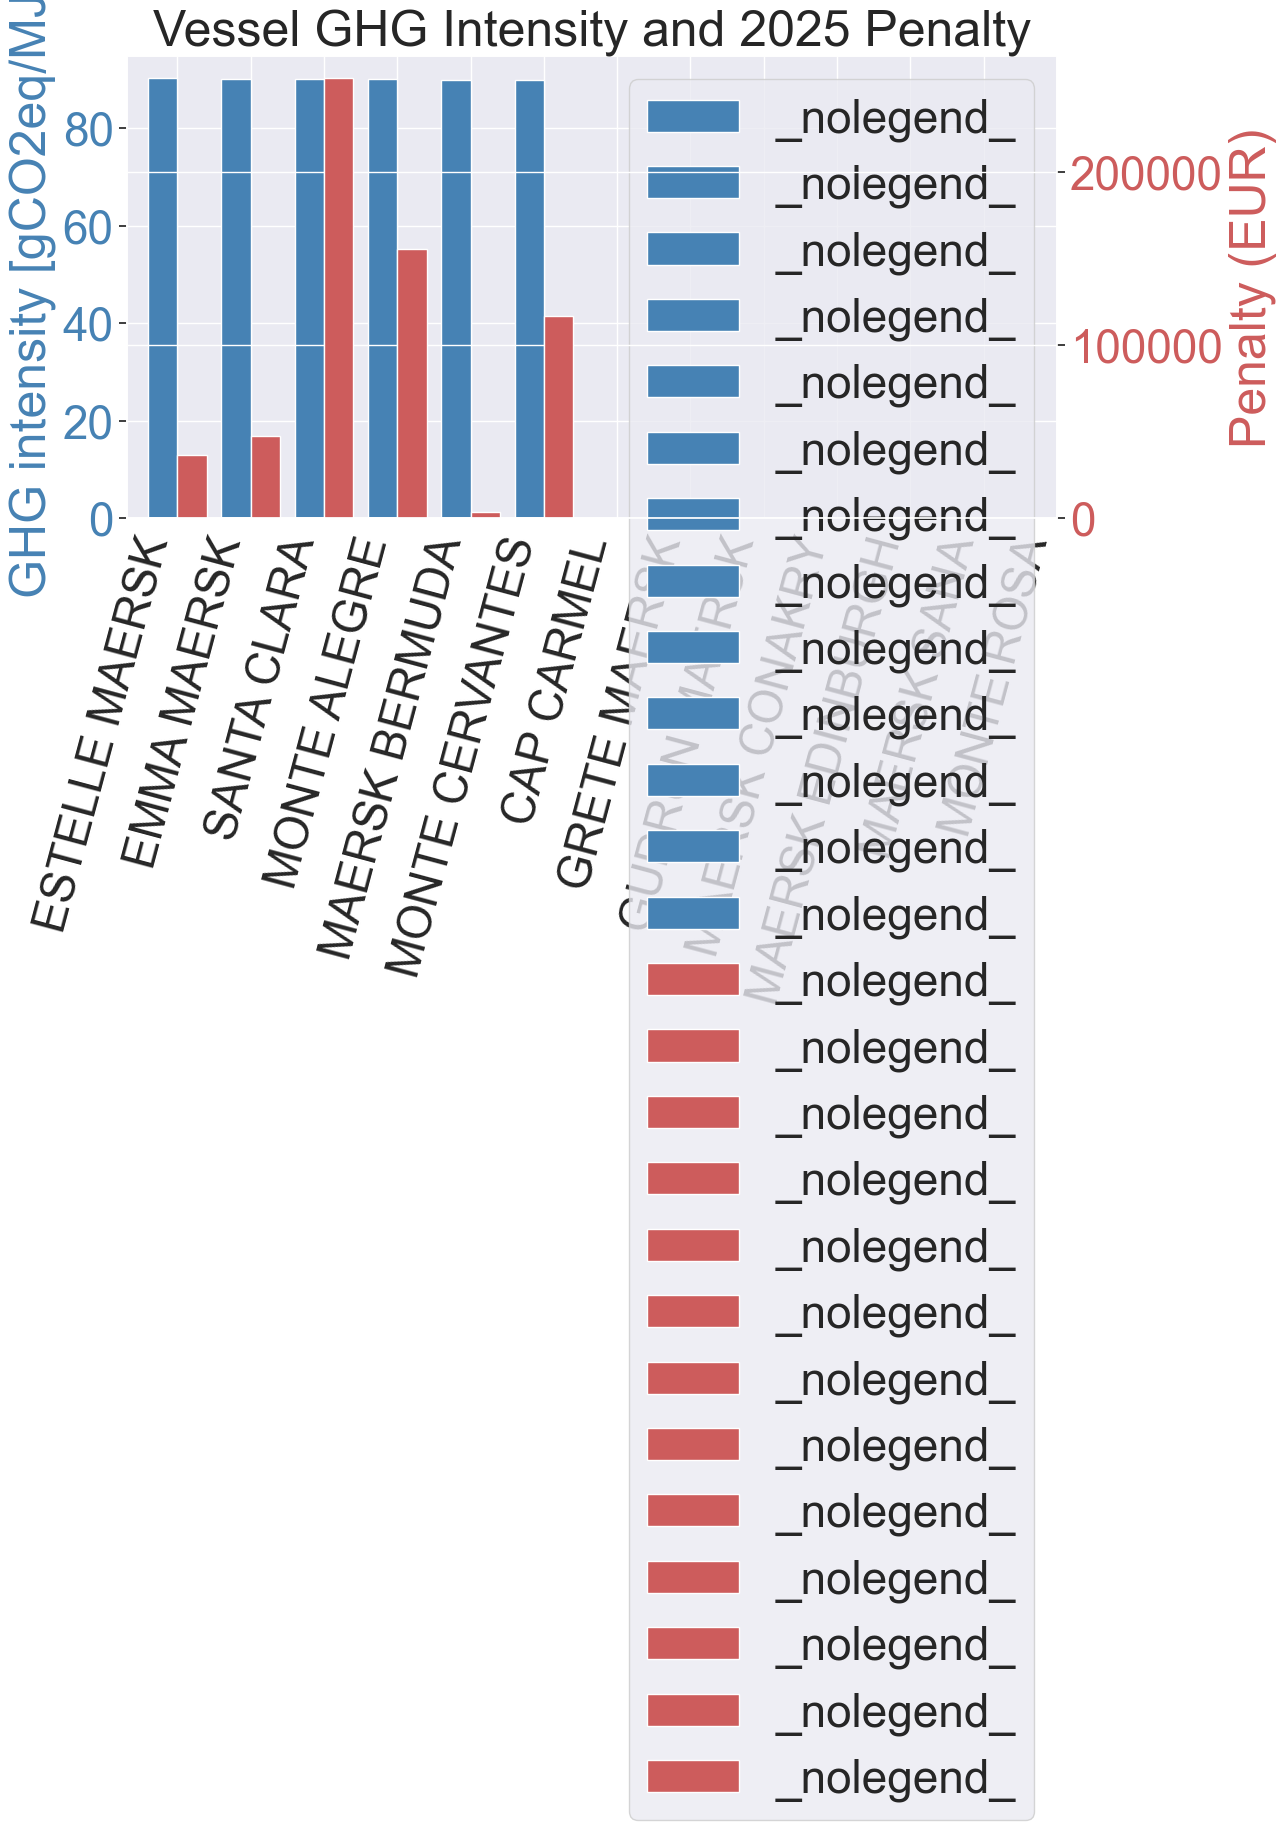

In [63]:

ghg_col = "GHG intensity [gCO2eq / MJ]"   # your actual column name
penalty_col = "2025 Penalty"              # your penalty column
vessel_col = "VesselName"

df_year = df_year.sort_values(ghg_col, ascending=False).reset_index(drop=True)

#Bar settings
x = np.arange(len(df_year)) #positions of the bars
width = 0.4 #width

# --- create plot ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis = GHG intensity
bars1 = ax1.bar(
    x - width/2,
    df_year[ghg_col],
    width,
    color='steelblue',
    label='GHG intensity [gCO2eq/MJ]'
)
ax1.set_ylabel("GHG intensity [gCO2eq/MJ]", color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# --- second axis for penalties ---
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    df_year[penalty_col],
    width,
    color='indianred',
    label='2025 Penalty (EUR)'
)
ax2.set_ylabel("Penalty (EUR)", color='indianred')
ax2.tick_params(axis='y', labelcolor='indianred')

# --- x-axis setup ---
ax1.set_xticks(x)
ax1.set_xticklabels(df_year[vessel_col], rotation=75, ha='right')

# --- title and legend ---
plt.title("Vessel GHG Intensity and 2025 Penalty")
fig.tight_layout()

# Combine legends from both axes
bars = bars1 + bars2
labels = [b.get_label() for b in bars]
ax1.legend(bars, labels, loc='upper right')

plt.show()


## EU ETS

In [64]:
#EU ETS accounts for emissions the same way as FuelEU - 100% intra-EEA ports, 50% between non EEA and EEA port, 0% for non-EEA ports
#2024 -> 40% allowances to surrender
#2025 -> 70% allowances to surrender
#2026 onwards -> 100% allowances to surrender
#Therefore, we can use the emissions taken from FuelEU calculations

def EU_ETS(FuelEU_output):

    EUA_price = 80

    data_EU_ETS = FuelEU_output.groupby(['VesselName', 'ReportingYear']).agg({'FuelEU_total_wtw [gCO2eq / MJ]' : 'sum', 'FuelEU Energy required to oxidise in ME [MJ]' : 'sum', 'FuelEU Energy required to oxidise in Aux [MJ]' : 'sum', 'FuelEU Energy required to oxidise in Boil [MJ]' : 'sum'})
    data_EU_ETS['FuelEU_total_wtw [tCO2eq]'] = (data_EU_ETS['FuelEU_total_wtw [gCO2eq / MJ]']/1000000)*((data_EU_ETS['FuelEU Energy required to oxidise in ME [MJ]']+data_EU_ETS['FuelEU Energy required to oxidise in Aux [MJ]'] + data_EU_ETS['FuelEU Energy required to oxidise in Boil [MJ]'])) #Turn gCo2eq / MJ to tCO2

    data_EU_ETS = data_EU_ETS.reset_index()

  # Apply ETS coverage based on year
    data_EU_ETS['coverage_factor'] = np.select(
        [
            data_EU_ETS['ReportingYear'] <= 2021,
            data_EU_ETS['ReportingYear'] == 2025
        ],
        [
            0.4,  # 40% in 2021
            0.7   # 70% in 2025
        ],
        default=1.0  # 100% after 2026
    )

    data_EU_ETS['EUA_to_surrender'] = data_EU_ETS['FuelEU_total_wtw [tCO2eq]'] * data_EU_ETS['coverage_factor']
    data_EU_ETS['Compliance_Cost (EUR)'] = data_EU_ETS['EUA_to_surrender'] * EUA_price

    return data_EU_ETS 

ETS_output = EU_ETS(FuelEU_output)
ETS_output


,VesselName,ReportingYear,FuelEU_total_wtw [gCO2eq / MJ],FuelEU Energy required to oxidise in ME [MJ],FuelEU Energy required to oxidise in Aux [MJ],FuelEU Energy required to oxidise in Boil [MJ],FuelEU_total_wtw [tCO2eq],coverage_factor,EUA_to_surrender,Compliance_Cost (EUR)
0,CAP CARMEL,2020,0.000000,0.0,0.0,0.0,0.000000,0.4,0.000000,0.000000e+00
1,CAP CARMEL,2021,0.000000,0.0,0.0,0.0,0.000000,0.4,0.000000,0.000000e+00
2,EMMA MAERSK,2020,90.053233,1772020.0,1760249.0,483800.0,361.659998,0.4,144.663999,1.157312e+04
3,EMMA MAERSK,2021,90.131703,59812701.5,27280749.5,5218892.0,8320.268726,0.4,3328.107490,2.662486e+05
4,ESTELLE MAERSK,2020,90.053659,1959800.0,973750.0,267115.0,288.231593,0.4,115.292637,9.223411e+03
5,ESTELLE MAERSK,2021,90.196584,40981157.5,21168790.0,3535020.0,5924.559672,0.4,2369.823869,1.895859e+05
6,GRETE MAERSK,2020,0.000000,0.0,0.0,0.0,0.000000,0.4,0.000000,0.000000e+00
7,GRETE MAERSK,2021,0.000000,0.0,0.0,0.0,0.000000,0.4,0.000000,0.000000e+00
8,GUDRUN MAERSK,2020,0.000000,0.0,0.0,0.0,0.000000,0.4,0.000000,0.000000e+00
9,GUDRUN MAERSK,2021,0.000000,0.0,0.0,0.0,0.000000,0.4,0.000000,0.000000e+00


          VesselName  ReportingYear  FuelEU_total_wtw [gCO2eq / MJ]  \
25       SANTA CLARA           2021                       90.053575   
21   MONTE CERVANTES           2021                       89.844464   
19      MONTE ALEGRE           2021                       90.030380   
3        EMMA MAERSK           2021                       90.131703   
5     ESTELLE MAERSK           2021                       90.196584   
18      MONTE ALEGRE           2020                       90.040389   
11    MAERSK BERMUDA           2021                       89.896290   
10    MAERSK BERMUDA           2020                       90.047873   
2        EMMA MAERSK           2020                       90.053233   
4     ESTELLE MAERSK           2020                       90.053659   
20   MONTE CERVANTES           2020                       90.052350   
8      GUDRUN MAERSK           2020                        0.000000   
9      GUDRUN MAERSK           2021                        0.000000   
6     

C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\4166959850.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:orange'` for the same effect.

  sns.barplot(
C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\4166959850.py:28: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\4166959850.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\MVA249\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


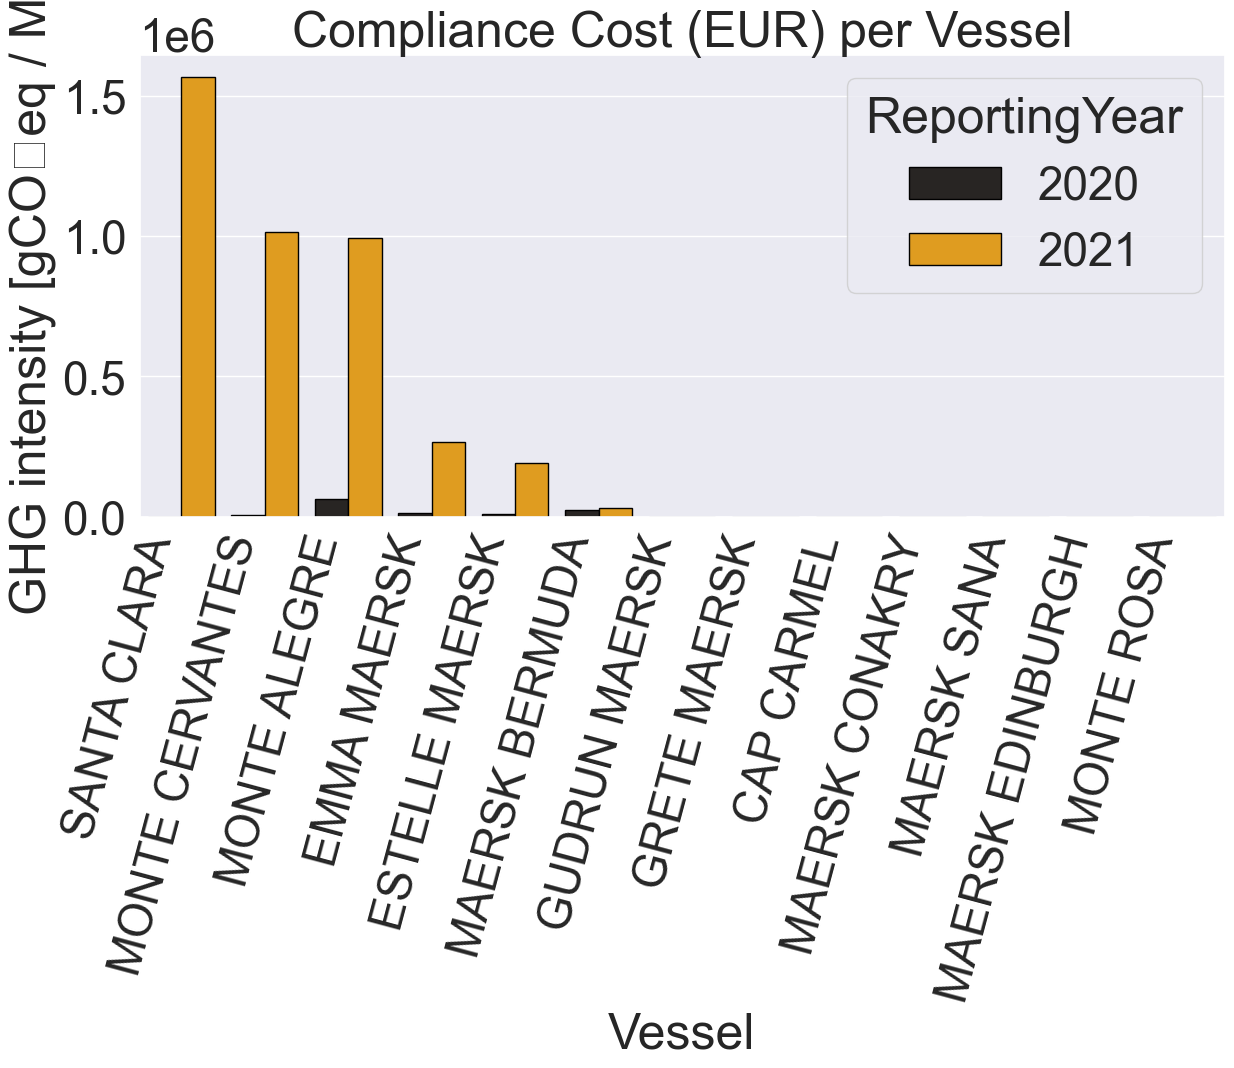

In [65]:
year = 2021
ETS_year = ETS_output.copy()

ETS_year = ETS_year.sort_values('Compliance_Cost (EUR)', ascending=False)

year_order = sorted(ETS_year['ReportingYear'].unique())

print(ETS_year)
plt.figure(figsize=(14, 6))

# --- Barplot: GHG intensity of each vessel in the chosen year ---
sns.barplot(
    data=ETS_year,
    x='VesselName',
    y='Compliance_Cost (EUR)',
    hue = 'ReportingYear',
    hue_order = year_order,
    color='orange',
    edgecolor='black',
    dodge=True  
)

# --- Formatting ---
plt.xticks(rotation=75, ha='right')
plt.ylabel('GHG intensity [gCO₂eq / MJ]')
plt.xlabel('Vessel')
plt.title('Compliance Cost (EUR) per Vessel')
plt.tight_layout()
plt.show()



## CII

In [ ]:
#define rating vectors (as per regulation)
#from MEPC354(78)
d1 = 0.83 #maxA
d2 = 0.94 #maxB
d3 = 1.07 #maxC
d4 = 1.19 #maxD

#from MEPC353(78)
a = 1984
c = 0.489

#Reduction Factor 
#from MEPC.400(83) 2023-2030, remaining years have a linear increase until reaching 100% in 2050
Z = [0,0.05,0.07,0.09,0.11,0.13625,0.1625,0.18875,0.215, 0.25425, 0.2935, 0.33275, 0.372, 0.41125, 0.4505, 0.48975, 0.529, 0.56825, 0.6075, 0.64675, 0.686, 0.72525, 0.7645, 0.80375, 0.843, 0.88225, 0.9215, 0.96075, 1.0] #reduction factors from 2019 until 2030 (as per regulation)

years = [2019,2023,2024,2025,2026,2027,2028,2029,2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050] #corresponding years



In [75]:
def CII_analysis(data):    
    #calculate Distance sailed based on what is reported in the DCS data
    #for 2021 data the port distances will be 0 but instead there is additional lines where these are reported as "DistanceGPS"
    data_CII = data.groupby(["VesselName","ReportingYear"]).agg({"Total CO2 Emissions [tCO2eq]":"sum", "DistanceGPS":"sum"})
    data_CII = data_CII.reset_index()
    data_CII["Total Distance Sailed GPS"] = data_CII["DistanceGPS"] #sum up all available GPS datapoints
    
    #get DWT into the previous dataframe
    #will only be left with the subset of ships for which we have the ship particular information
    data_CII = data_CII.merge(ship_particulars[['VesselName', 'Deadweight @ scantling tons']], on="VesselName", how="inner")
    
    #calculate Annual Efficiency Ratio (AER)
    data_CII["AER"] = data_CII["Total CO2 Emissions [tCO2eq]"]*1000000/(data_CII["Total Distance Sailed GPS"]*data_CII["Deadweight @ scantling tons"])
               
    #define the CII rating for all years (business as usual scenario)
    #show what would happen to the rating if the AER of the ships wouldn't change through additional measures
    #use this as an initial overview
    index = 0

    for z in Z:
        #calculate required AER value to be in a certain rating category
        data_CII["Required CII_{}".format(years[index])] = ((1-z)/1)*a*data_CII["Deadweight @ scantling tons"]**(-c) #midpoint of C
        data_CII["Required CII_{}_forA".format(years[index])] = data_CII["Required CII_{}".format(years[index])]*d1 #max possible value for an A
        data_CII["Required CII_{}_forB".format(years[index])] = data_CII["Required CII_{}".format(years[index])]*d2 #max possible value for a B
        data_CII["Required CII_{}_forC".format(years[index])] = data_CII["Required CII_{}".format(years[index])]*d3 #max possible value for a C
        data_CII["Required CII_{}_forD".format(years[index])] = data_CII["Required CII_{}".format(years[index])]*d4 #max possible value for a D
        index += 1

    for x in data_CII.index:
        #put the CII rating category for each year and vessel for all the years (business as usual scenario)
        #based on the reported AER and what would be the required AER of the particular year
        for year in years:
            if data_CII.loc[x,"AER"] <= data_CII.loc[x,"Required CII_{}_forA".format(year)]: 
                data_CII.loc[x,"CII_rating_{}".format(year)] = "A"
            elif data_CII.loc[x,"AER"] <= data_CII.loc[x,"Required CII_{}_forB".format(year)]:
                data_CII.loc[x,"CII_rating_{}".format(year)] = "B"
            elif data_CII.loc[x,"AER"] <= data_CII.loc[x,"Required CII_{}_forC".format(year)]:
                data_CII.loc[x,"CII_rating_{}".format(year)] = "C"
            elif data_CII.loc[x,"AER"] <= data_CII.loc[x,"Required CII_{}_forD".format(year)]:
                data_CII.loc[x,"CII_rating_{}".format(year)] = "D"
            else: data_CII.loc[x,"CII_rating_{}".format(year)] = "E" #if higher than the max value for D, put an E rating
            
    return data_CII

In [68]:
data_CII = CII_analysis(data_all)

C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\2009504764.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_CII["Required CII_{}".format(years[index])] = ((1-z)/1)*a*data_CII["Deadweight @ scantling tons"]**(-c) #midpoint of C
C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\2009504764.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_CII["Required CII_{}_forA".format(years[index])] = data_CII["Required CII_{}".format(years[index])]*d1 #max possible value for an A
C:\Users\MVA249\AppData\Local\Temp\ipykerne

In [69]:
data_CII

,VesselName,ReportingYear,Total CO2 Emissions [tCO2eq],DistanceGPS,Total Distance Sailed GPS,Deadweight @ scantling tons,AER,Required CII_2019,Required CII_2019_forA,Required CII_2019_forB,Required CII_2019_forC,Required CII_2019_forD,Required CII_2023,Required CII_2023_forA,Required CII_2023_forB,Required CII_2023_forC,Required CII_2023_forD,Required CII_2024,Required CII_2024_forA,Required CII_2024_forB,Required CII_2024_forC,Required CII_2024_forD,Required CII_2025,Required CII_2025_forA,Required CII_2025_forB,Required CII_2025_forC,Required CII_2025_forD,Required CII_2026,Required CII_2026_forA,Required CII_2026_forB,Required CII_2026_forC,Required CII_2026_forD,Required CII_2027,Required CII_2027_forA,Required CII_2027_forB,Required CII_2027_forC,Required CII_2027_forD,Required CII_2028,Required CII_2028_forA,Required CII_2028_forB,Required CII_2028_forC,Required CII_2028_forD,Required CII_2029,Required CII_2029_forA,Required CII_2029_forB,Required CII_2029_forC,Required CII_2029_forD,Required CII_2030,Required CII_2030_forA,Required CII_2030_forB,Required CII_2030_forC,Required CII_2030_forD,Required CII_2031,Required CII_2031_forA,Required CII_2031_forB,Required CII_2031_forC,Required CII_2031_forD,Required CII_2032,Required CII_2032_forA,Required CII_2032_forB,Required CII_2032_forC,Required CII_2032_forD,Required CII_2033,Required CII_2033_forA,Required CII_2033_forB,Required CII_2033_forC,Required CII_2033_forD,Required CII_2034,Required CII_2034_forA,Required CII_2034_forB,Required CII_2034_forC,Required CII_2034_forD,Required CII_2035,Required CII_2035_forA,Required CII_2035_forB,Required CII_2035_forC,Required CII_2035_forD,Required CII_2036,Required CII_2036_forA,Required CII_2036_forB,Required CII_2036_forC,Required CII_2036_forD,Required CII_2037,Required CII_2037_forA,Required CII_2037_forB,Required CII_2037_forC,Required CII_2037_forD,Required CII_2038,Required CII_2038_forA,Required CII_2038_forB,Required CII_2038_forC,Required CII_2038_forD,Required CII_2039,Required CII_2039_forA,Required CII_2039_forB,Required CII_2039_forC,Required CII_2039_forD,Required CII_2040,Required CII_2040_forA,Required CII_2040_forB,Required CII_2040_forC,Required CII_2040_forD,Required CII_2041,Required CII_2041_forA,Required CII_2041_forB,Required CII_2041_forC,Required CII_2041_forD,Required CII_2042,Required CII_2042_forA,Required CII_2042_forB,Required CII_2042_forC,Required CII_2042_forD,Required CII_2043,Required CII_2043_forA,Required CII_2043_forB,Required CII_2043_forC,Required CII_2043_forD,Required CII_2044,Required CII_2044_forA,Required CII_2044_forB,Required CII_2044_forC,Required CII_2044_forD,Required CII_2045,Required CII_2045_forA,Required CII_2045_forB,Required CII_2045_forC,Required CII_2045_forD,Required CII_2046,Required CII_2046_forA,Required CII_2046_forB,Required CII_2046_forC,Required CII_2046_forD,Required CII_2047,Required CII_2047_forA,Required CII_2047_forB,Required CII_2047_forC,Required CII_2047_forD,Required CII_2048,Required CII_2048_forA,Required CII_2048_forB,Required CII_2048_forC,Required CII_2048_forD,Required CII_2049,Required CII_2049_forA,Required CII_2049_forB,Required CII_2049_forC,Required CII_2049_forD,Required CII_2050,Required CII_2050_forA,Required CII_2050_forB,Required CII_2050_forC,Required CII_2050_forD,CII_rating_2019,CII_rating_2023,CII_rating_2024,CII_rating_2025,CII_rating_2026,CII_rating_2027,CII_rating_2028,CII_rating_2029,CII_rating_2030,CII_rating_2031,CII_rating_2032,CII_rating_2033,CII_rating_2034,CII_rating_2035,CII_rating_2036,CII_rating_2037,CII_rating_2038,CII_rating_2039,CII_rating_2040,CII_rating_2041,CII_rating_2042,CII_rating_2043,CII_rating_2044,CII_rating_2045,CII_rating_2046,CII_rating_2047,CII_rating_2048,CII_rating_2049,CII_rating_2050
0,CAP CARMEL,2020,280.625673,2810.346535,2810.346535,33891,2.946342,12.087331,10.032484,11.362091,12.933444,14.383924,11.482964,9.530860,10.793986,12.286772,13.664727,11.241218,9.330211,10.566744,12.028103,13.377049,10.99

In [70]:
data_CII = data_CII[data_CII['ReportingYear'] == 2021].reset_index(drop=True)

In [71]:
data_CII

,VesselName,ReportingYear,Total CO2 Emissions [tCO2eq],DistanceGPS,Total Distance Sailed GPS,Deadweight @ scantling tons,AER,Required CII_2019,Required CII_2019_forA,Required CII_2019_forB,Required CII_2019_forC,Required CII_2019_forD,Required CII_2023,Required CII_2023_forA,Required CII_2023_forB,Required CII_2023_forC,Required CII_2023_forD,Required CII_2024,Required CII_2024_forA,Required CII_2024_forB,Required CII_2024_forC,Required CII_2024_forD,Required CII_2025,Required CII_2025_forA,Required CII_2025_forB,Required CII_2025_forC,Required CII_2025_forD,Required CII_2026,Required CII_2026_forA,Required CII_2026_forB,Required CII_2026_forC,Required CII_2026_forD,Required CII_2027,Required CII_2027_forA,Required CII_2027_forB,Required CII_2027_forC,Required CII_2027_forD,Required CII_2028,Required CII_2028_forA,Required CII_2028_forB,Required CII_2028_forC,Required CII_2028_forD,Required CII_2029,Required CII_2029_forA,Required CII_2029_forB,Required CII_2029_forC,Required CII_2029_forD,Required CII_2030,Required CII_2030_forA,Required CII_2030_forB,Required CII_2030_forC,Required CII_2030_forD,Required CII_2031,Required CII_2031_forA,Required CII_2031_forB,Required CII_2031_forC,Required CII_2031_forD,Required CII_2032,Required CII_2032_forA,Required CII_2032_forB,Required CII_2032_forC,Required CII_2032_forD,Required CII_2033,Required CII_2033_forA,Required CII_2033_forB,Required CII_2033_forC,Required CII_2033_forD,Required CII_2034,Required CII_2034_forA,Required CII_2034_forB,Required CII_2034_forC,Required CII_2034_forD,Required CII_2035,Required CII_2035_forA,Required CII_2035_forB,Required CII_2035_forC,Required CII_2035_forD,Required CII_2036,Required CII_2036_forA,Required CII_2036_forB,Required CII_2036_forC,Required CII_2036_forD,Required CII_2037,Required CII_2037_forA,Required CII_2037_forB,Required CII_2037_forC,Required CII_2037_forD,Required CII_2038,Required CII_2038_forA,Required CII_2038_forB,Required CII_2038_forC,Required CII_2038_forD,Required CII_2039,Required CII_2039_forA,Required CII_2039_forB,Required CII_2039_forC,Required CII_2039_forD,Required CII_2040,Required CII_2040_forA,Required CII_2040_forB,Required CII_2040_forC,Required CII_2040_forD,Required CII_2041,Required CII_2041_forA,Required CII_2041_forB,Required CII_2041_forC,Required CII_2041_forD,Required CII_2042,Required CII_2042_forA,Required CII_2042_forB,Required CII_2042_forC,Required CII_2042_forD,Required CII_2043,Required CII_2043_forA,Required CII_2043_forB,Required CII_2043_forC,Required CII_2043_forD,Required CII_2044,Required CII_2044_forA,Required CII_2044_forB,Required CII_2044_forC,Required CII_2044_forD,Required CII_2045,Required CII_2045_forA,Required CII_2045_forB,Required CII_2045_forC,Required CII_2045_forD,Required CII_2046,Required CII_2046_forA,Required CII_2046_forB,Required CII_2046_forC,Required CII_2046_forD,Required CII_2047,Required CII_2047_forA,Required CII_2047_forB,Required CII_2047_forC,Required CII_2047_forD,Required CII_2048,Required CII_2048_forA,Required CII_2048_forB,Required CII_2048_forC,Required CII_2048_forD,Required CII_2049,Required CII_2049_forA,Required CII_2049_forB,Required CII_2049_forC,Required CII_2049_forD,Required CII_2050,Required CII_2050_forA,Required CII_2050_forB,Required CII_2050_forC,Required CII_2050_forD,CII_rating_2019,CII_rating_2023,CII_rating_2024,CII_rating_2025,CII_rating_2026,CII_rating_2027,CII_rating_2028,CII_rating_2029,CII_rating_2030,CII_rating_2031,CII_rating_2032,CII_rating_2033,CII_rating_2034,CII_rating_2035,CII_rating_2036,CII_rating_2037,CII_rating_2038,CII_rating_2039,CII_rating_2040,CII_rating_2041,CII_rating_2042,CII_rating_2043,CII_rating_2044,CII_rating_2045,CII_rating_2046,CII_rating_2047,CII_rating_2048,CII_rating_2049,CII_rating_2050
0,CAP CARMEL,2021,5459.015493,60155.40,60155.40,33891,2.677659,12.087331,10.032484,11.362091,12.933444,14.383924,11.482964,9.530860,10.793986,12.286772,13.664727,11.241218,9.330211,10.566744,12.028103,13.377049,10.999471,

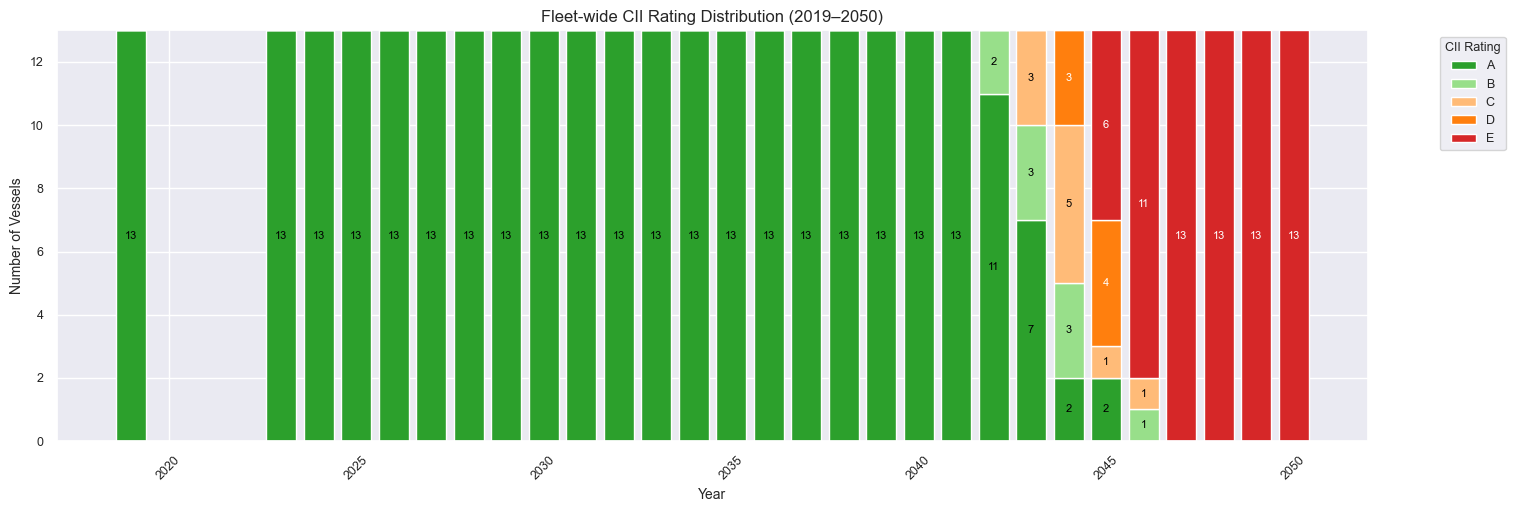

In [78]:
fleet_dist = pd.DataFrame(index=years, columns=["A","B","C","D","E"])

for year in years:
    counts = data_CII[f"CII_rating_{year}"].value_counts()
    for rating in ["A","B","C","D","E"]:
        fleet_dist.loc[year, rating] = counts.get(rating, 0)  # default 0 if no ships in that rating

fleet_dist = fleet_dist.astype(int)

colors = {
    "A": "#2ca02c",  # green
    "B": "#98df8a",  # light green
    "C": "#ffbb78",  # orange
    "D": "#ff7f0e",  # dark orange
    "E": "#d62728"   # red
}

fig, ax = plt.subplots(figsize=(16,6))

bottom = pd.Series([0]*len(fleet_dist), index=fleet_dist.index)
for rating in ["A","B","C","D","E"]:
    bars = ax.bar(fleet_dist.index, fleet_dist[rating], bottom=bottom, color=colors[rating], label=rating)
  
    for bar, value, btm in zip(bars, fleet_dist[rating], bottom):
        if value > 0:  # only annotate if >0
            text_color = 'white' if rating in ["D","E"] else 'black'
            ax.text(
                bar.get_x() + bar.get_width()/2,  # x-position (center of bar)
                btm + value/2,                    # y-position (middle of segment)
                str(int(value)),                   # text
                ha='center', va='center', fontsize=8, color=text_color
            )
    bottom += fleet_dist[rating]


ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number of Vessels", fontsize=10)
ax.set_title("Fleet-wide CII Rating Distribution (2019–2050)", fontsize=12)
ax.tick_params(axis='x', labelsize=9, rotation=45)
ax.tick_params(axis='y', labelsize=9)

ax.legend(title="CII Rating", title_fontsize=9, fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Net Zero Framework

In [79]:
#annual reduction factor Zt
#from ?
#Base target
Z_t1 = [0.04, 0.06, 0.08, 0.124, 0.168, 0.212, 0.256, 0.30, 0.37, 0.44, 0.51,0.58, 0.65, 0.685, 0.72, 0.755, 0.79, 0.825, 0.86, 0.895, 0.93, 0.965, 1.0]

#direct compliance target
Z_t2 = [0.17, 0.19, 0.21, 0.254, 0.298, 0.342, 0.386, 0.43,0.468, 0.506, 0.544, 0.582, 0.620, 0.658, 0.696, 0.734, 0.772, 0.810, 0.848, 0.886, 0.924, 0.962, 1.00]

yearsNZF = [2028,2029,2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050] #corresponding years

In [87]:
data_NZF = pd.DataFrame()
data_NZF[['VesselName', 'ReportingYear','GHG intensity [gCO2eq]']] = FuelEU_output[['VesselName', 'ReportingYear',"FuelEU_total_wtw [gCO2eq / MJ]"]]
data_NZF = data_all.groupby(["VesselName","ReportingYear"]).agg({"Total CO2 Emissions [tCO2eq]":"sum"})
data_NZF = data_NZF.reset_index()  # makes VesselName and ReportingYear columns if they were index
data_NZF = data_NZF[data_NZF['ReportingYear'] == 2021].reset_index(drop=True)

data_NZF = data_NZF.merge(
    data_comp[['VesselName', 'ReportingYear', 'GHG intensity [gCO2eq]','Total energy']],
    on=['VesselName', 'ReportingYear'],
    how='left'
)

data_NZF['GFI_attained [gCO2eq/MJ]'] = data_NZF['GHG intensity [gCO2eq]'] / data_NZF['Total energy']


# Step 3: Check result
data_NZF

,VesselName,ReportingYear,Total CO2 Emissions [tCO2eq],GHG intensity [gCO2eq],Total energy,GFI_attained [gCO2eq/MJ]
0,ADRIAN MAERSK,2021,17069.292530,NaN,NaN,NaN
1,ALBERT MAERSK,2021,17656.798287,NaN,NaN,NaN
2,ALEXANDER MAERSK,2021,2567.092828,NaN,NaN,NaN
3,ALIANCA LEBLON,2021,4494.311938,NaN,NaN,NaN
4,ALIANCA MANAUS,2021,4396.196384,NaN,NaN,NaN
...,...,...,...,...,...,...
295,VENTA MAERSK,2021,3891.984484,NaN,NaN,NaN
296,VICENTE PINZON,2021,9484.668210,NaN,NaN,NaN
297,VILNIA MAERSK,2021,4034.582816,NaN,NaN,NaN
298,VOLGA MAERSK,2021,4047.599629,NaN,NaN,NaN


In [89]:
data_NZF_clean = data_NZF.dropna(subset=['GHG intensity [gCO2eq]'])


In [90]:
data_nzf_compliance = data_NZF_clean.copy()

# Base value for target calculation
GFI_ref = 93.3  # gCO2eq/MJ

# Loop over years and their corresponding Z_t1 and Z_t2 values
for i, year in enumerate(yearsNZF):
    # Base and Direct Compliance GFI targets
    data_nzf_compliance[f'GFI_base_{year} [gCO2eq/MJ]'] = (1 - Z_t1[i]) * GFI_ref
    data_nzf_compliance[f'GFI_direct_{year} [gCO2eq/MJ]'] = (1 - Z_t2[i]) * GFI_ref
    
    # Compliance Balance = (Direct target - GFI_attained) * Total energy
    data_nzf_compliance[f'Compliance_balance_{year} [gCO2eq]'] = (
        (data_nzf_compliance[f'GFI_direct_{year} [gCO2eq/MJ]'] - data_nzf_compliance['GFI_attained [gCO2eq/MJ]'])
        * data_nzf_compliance['Total energy']
    )
    
    # Compliance Status
    data_nzf_compliance[f'Compliance_status_{year}'] = data_nzf_compliance[f'Compliance_balance_{year} [gCO2eq]'].apply(
        lambda x: 'Direct Compliance' if x >= 0 else 'Compliance Deficit'
    )
    
    # Tier 1: Direct - Base
    data_nzf_compliance[f'Tier1_deficit_{year} [gCO2eq]'] = (
        (data_nzf_compliance[f'GFI_direct_{year} [gCO2eq/MJ]'] - data_nzf_compliance[f'GFI_base_{year} [gCO2eq/MJ]'])
        * data_nzf_compliance['Total energy']
    )
    
    # Tier 2: Base - Attained
    data_nzf_compliance[f'Tier2_deficit_{year} [gCO2eq]'] = (
        (data_nzf_compliance[f'GFI_base_{year} [gCO2eq/MJ]'] - data_nzf_compliance['GFI_attained [gCO2eq/MJ]'])
        * data_nzf_compliance['Total energy']
    )

C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\646366381.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_nzf_compliance[f'GFI_direct_{year} [gCO2eq/MJ]'] = (1 - Z_t2[i]) * GFI_ref
C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\646366381.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_nzf_compliance[f'Compliance_balance_{year} [gCO2eq]'] = (
C:\Users\MVA249\AppData\Local\Temp\ipykernel_14964\646366381.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [91]:
data_nzf_compliance

,VesselName,ReportingYear,Total CO2 Emissions [tCO2eq],GHG intensity [gCO2eq],Total energy,GFI_attained [gCO2eq/MJ],GFI_base_2028 [gCO2eq/MJ],GFI_direct_2028 [gCO2eq/MJ],Compliance_balance_2028 [gCO2eq],Compliance_status_2028,Tier1_deficit_2028 [gCO2eq],Tier2_deficit_2028 [gCO2eq],GFI_base_2029 [gCO2eq/MJ],GFI_direct_2029 [gCO2eq/MJ],Compliance_balance_2029 [gCO2eq],Compliance_status_2029,Tier1_deficit_2029 [gCO2eq],Tier2_deficit_2029 [gCO2eq],GFI_base_2030 [gCO2eq/MJ],GFI_direct_2030 [gCO2eq/MJ],Compliance_balance_2030 [gCO2eq],Compliance_status_2030,Tier1_deficit_2030 [gCO2eq],Tier2_deficit_2030 [gCO2eq],GFI_base_2031 [gCO2eq/MJ],GFI_direct_2031 [gCO2eq/MJ],Compliance_balance_2031 [gCO2eq],Compliance_status_2031,Tier1_deficit_2031 [gCO2eq],Tier2_deficit_2031 [gCO2eq],GFI_base_2032 [gCO2eq/MJ],GFI_direct_2032 [gCO2eq/MJ],Compliance_balance_2032 [gCO2eq],Compliance_status_2032,Tier1_deficit_2032 [gCO2eq],Tier2_deficit_2032 [gCO2eq],GFI_base_2033 [gCO2eq/MJ],GFI_direct_2033 [gCO2eq/MJ],Compliance_balance_2033 [gCO2eq],Compliance_status_2033,Tier1_deficit_2033 [gCO2eq],Tier2_deficit_2033 [gCO2eq],GFI_base_2034 [gCO2eq/MJ],GFI_direct_2034 [gCO2eq/MJ],Compliance_balance_2034 [gCO2eq],Compliance_status_2034,Tier1_deficit_2034 [gCO2eq],Tier2_deficit_2034 [gCO2eq],GFI_base_2035 [gCO2eq/MJ],GFI_direct_2035 [gCO2eq/MJ],Compliance_balance_2035 [gCO2eq],Compliance_status_2035,Tier1_deficit_2035 [gCO2eq],Tier2_deficit_2035 [gCO2eq],GFI_base_2036 [gCO2eq/MJ],GFI_direct_2036 [gCO2eq/MJ],Compliance_balance_2036 [gCO2eq],Compliance_status_2036,Tier1_deficit_2036 [gCO2eq],Tier2_deficit_2036 [gCO2eq],GFI_base_2037 [gCO2eq/MJ],GFI_direct_2037 [gCO2eq/MJ],Compliance_balance_2037 [gCO2eq],Compliance_status_2037,Tier1_deficit_2037 [gCO2eq],Tier2_deficit_2037 [gCO2eq],GFI_base_2038 [gCO2eq/MJ],GFI_direct_2038 [gCO2eq/MJ],Compliance_balance_2038 [gCO2eq],Compliance_status_2038,Tier1_deficit_2038 [gCO2eq],Tier2_deficit_2038 [gCO2eq],GFI_base_2039 [gCO2eq/MJ],GFI_direct_2039 [gCO2eq/MJ],Compliance_balance_2039 [gCO2eq],Compliance_status_2039,Tier1_deficit_2039 [gCO2eq],Tier2_deficit_2039 [gCO2eq],GFI_base_2040 [gCO2eq/MJ],GFI_direct_2040 [gCO2eq/MJ],Compliance_balance_2040 [gCO2eq],Compliance_status_2040,Tier1_deficit_2040 [gCO2eq],Tier2_deficit_2040 [gCO2eq],GFI_base_2041 [gCO2eq/MJ],GFI_direct_2041 [gCO2eq/MJ],Compliance_balance_2041 [gCO2eq],Compliance_status_2041,Tier1_deficit_2041 [gCO2eq],Tier2_deficit_2041 [gCO2eq],GFI_base_2042 [gCO2eq/MJ],GFI_direct_2042 [gCO2eq/MJ],Compliance_balance_2042 [gCO2eq],Compliance_status_2042,Tier1_deficit_2042 [gCO2eq],Tier2_deficit_2042 [gCO2eq],GFI_base_2043 [gCO2eq/MJ],GFI_direct_2043 [gCO2eq/MJ],Compliance_balance_2043 [gCO2eq],Compliance_status_2043,Tier1_deficit_2043 [gCO2eq],Tier2_deficit_2043 [gCO2eq],GFI_base_2044 [gCO2eq/MJ],GFI_direct_2044 [gCO2eq/MJ],Compliance_balance_2044 [gCO2eq],Compliance_status_2044,Tier1_deficit_2044 [gCO2eq],Tier2_deficit_2044 [gCO2eq],GFI_base_2045 [gCO2eq/MJ],GFI_direct_2045 [gCO2eq/MJ],Compliance_balance_2045 [gCO2eq],Compliance_status_2045,Tier1_deficit_2045 [gCO2eq],Tier2_deficit_2045 [gCO2eq],GFI_base_2046 [gCO2eq/MJ],GFI_direct_2046 [gCO2eq/MJ],Compliance_balance_2046 [gCO2eq],Compliance_status_2046,Tier1_deficit_2046 [gCO2eq],Tier2_deficit_2046 [gCO2eq],GFI_base_2047 [gCO2eq/MJ],GFI_direct_2047 [gCO2eq/MJ],Compliance_balance_2047 [gCO2eq],Compliance_status_2047,Tier1_deficit_2047 [gCO2eq],Tier2_deficit_2047 [gCO2eq],GFI_base_2048 [gCO2eq/MJ],GFI_direct_2048 [gCO2eq/MJ],Compliance_balance_2048 [gCO2eq],Compliance_status_2048,Tier1_deficit_2048 [gCO2eq],Tier2_deficit_2048 [gCO2eq],GFI_base_2049 [gCO2eq/MJ],GFI_direct_2049 [gCO2eq/MJ],Compliance_balance_2049 [gCO2eq],Compliance_status_2049,Tier1_deficit_2049 [gCO2eq],Tier2_deficit_2049 [gCO2eq],GFI_base_2050 [gCO2eq/MJ],GFI_direct_2050 [gCO2eq/MJ],Compliance_balance_2050 [gCO2eq],Compliance_status_2050,Tier1_deficit_2050 [gCO2eq],Tier2_deficit_2050 [gCO2eq]
25,EMMA MAERSK,2021,17518.205282,8.320269e+09,92312343.0,90.131703